# Mental Health in the Tech Industry Dataset Analysis (Module 2, Sprint 1)

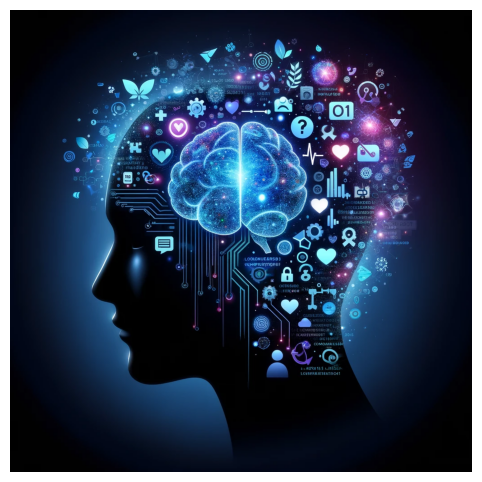

In [212]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('Mental_Health_Tech_Image.png')
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

## **Introduction**

This project contains analysis of Mental Health in the Tech Industry dataset, downloaded from:
https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry as a mental_health.sqlite file.

This data is from <ins>Open Source Mental Illness (OSMI)</ins> using survey data from years 2014, 2016, 2017, 2018 and 2019. Each survey measures and attitudes towards mental health and frequency of mental health disorders in the tech workplace.

The raw data was processed using Python, SQL and Excel for cleaning and manipulation.

The analysis is structured into different parts:

1. Data loading and initial inspection (using SQLite)
2. Thourough Data Exploration: Sociodemographic Features and Prevalence Analysis (using SQLite)
3. Create a final SQL Query for EDA 
4. Exploratory Data Analysis (Bivariant Analysis) and Correlation Analysis
5. Summary of EDA and Insights
6. Improvements

## **1. Data Loading**

### **<ins>1.1 Import necessary modules, libraries and packages:</ins>**

In [229]:
import pandas as pd 
import numpy as np
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image, display
from scipy.stats import norm, pearsonr, spearmanr
from scipy.stats import f_oneway
from scipy import stats
import viz_utils as viz

### **<ins>1.2. Connecting to SQL Database</ins>**

In [379]:
conn = sqlite3.connect('mental_health.sqlite')
cursor = conn.cursor()

print(f"File exists: {os.path.exists('mental_health.sqlite')}")
print(f"File size: {os.path.getsize('mental_health.sqlite')} bytes")

File exists: True
File size: 5890048 bytes


### SQL Terminology Used in This Notebook

- **Table Aliases**: Short labels used to refer to tables in SQL queries (e.g., `a` for Answer table)
- **JOIN**: SQL operation to combine rows from multiple tables based on related columns
- **SQL Pivot**: Technique to transform data from rows to columns (using `MAX(CASE WHEN...)` statements)
- **SurveyID**: Identifier for which year's survey the data belongs to (e.g., 2014, 2016)
- **UserID**: Unique identifier for each survey respondent
- **QuestionID**: Identifier for each survey question
- **AnswerText**: The actual response provided by a user to a specific question
- **GROUP BY**: SQL clause used to aggregate results by specified columns
- **Aggregation Functions**: Functions like MAX(), COUNT() that perform calculations on grouped data

### Table Aliases Used in SQL Queries

- `a`: Answer table - contains all individual survey responses
- `q`: Question table - contains the text of each survey question
- `s`: Survey table - contains metadata about each year's survey

### **<ins>1.3. Explore the Database and Table Structure</ins>**

In [93]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(f"- {table[0]}")

Tables in the database:
- Answer
- Question
- Survey


In [94]:
def explore_table(table_name, conn):
    cursor = conn.cursor()
    
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    
    print(f"\n=== Table: {table_name} ===")
    print("Columns:")
    for col in columns:
        print(f"- {col[1]} ({col[2]})")
    
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    row_count = cursor.fetchone()[0]
    print(f"Total rows: {row_count}")
    
    cursor.execute(f"SELECT * FROM {table_name} LIMIT 5")
    sample_data = cursor.fetchall()
    
    column_names = [col[1] for col in columns]
    
    return pd.DataFrame(sample_data, columns=column_names)

for table in tables:
    table_name = table[0]
    df_sample = explore_table(table_name, conn)
    print("\nSample data:")
    display(df_sample)


=== Table: Answer ===
Columns:
- AnswerText (VARCHAR(10000))
- SurveyID (INTEGER)
- UserID (INTEGER)
- QuestionID (INTEGER)
Total rows: 236898

Sample data:


,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1



=== Table: Question ===
Columns:
- questiontext (VARCHAR(1000))
- questionid (INTEGER)
Total rows: 105

Sample data:


,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state or territory do you live in?",4
4,Are you self-employed?,5



=== Table: Survey ===
Columns:
- SurveyID (INTEGER)
- Description (VARCHAR(255))
Total rows: 5

Sample data:


,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


#### **1.3.2 Number of unique users/respondents:**

In [95]:
user_count_query = """
SELECT COUNT(DISTINCT UserID) as UniqueUsers
FROM Answer
"""
user_count = pd.read_sql_query(user_count_query, conn)
display(user_count)

,UniqueUsers
0,4218


#### **1.3.3 Distribution of responses accross different surveys:**

In [96]:
survey_distribution_query = """
SELECT SurveyID, COUNT(DISTINCT UserID) as UserCount
FROM Answer
GROUP BY SurveyID
ORDER BY SurveyID
"""
survey_distribution = pd.read_sql_query(survey_distribution_query, conn)
display(survey_distribution)

,SurveyID,UserCount
0,2014,1260
1,2016,1433
2,2017,756
3,2018,417
4,2019,352


The unique User count of 4218 is also the sum of the User Count for each survey year (SurveyID) = 1260 + 1433 + 756 + 417 + 352. 

#### **1.3.4 Total Responses per Year**

In [97]:
total_response_per_year_query = """
SELECT SurveyID, COUNT(*) AS TotalResponses
FROM Answer
GROUP BY SurveyID
ORDER BY SurveyID ASC;

"""
df = pd.read_sql(total_response_per_year_query, conn)
df

,SurveyID,TotalResponses
0,2014,32760
1,2016,88238
2,2017,57456
3,2018,31692
4,2019,26752


<ins>The dataset has:</ins>

- **3 Tables**: Answer, Question, and Survey
- **5 Annual Surveys**: Mental health surveys from 2014-2019 (missing 2015)
- **105 Questions**: Including demographic and mental health-related questions
- **236,898 Responses**: Individual answers across all surveys

#### **1.3.5 How many questions were there to answer for each year?**

In [98]:
questions_per_year_query = """
SELECT SurveyID,
count(distinct QuestionID)
FROM Answer
GROUP BY SurveyID;
"""

questions_per_year = pd.read_sql(questions_per_year_query, conn)

questions_per_year

,SurveyID,count(distinct QuestionID)
0,2014,26
1,2016,60
2,2017,76
3,2018,76
4,2019,76


#### **1.3.6 Summary of survey year, distinct QuestionID, Responses and average Responser per User and Question:**

After seeing these results, we can determine if there's a real discrepancy or if the numbers make sense based on the survey structure.

In [273]:
comprehensive_summary_query = """
SELECT 
    a.SurveyID,
    COUNT(DISTINCT a.UserID) AS UniqueUsers,
    COUNT(DISTINCT a.QuestionID) AS UniqueQuestions,
    COUNT(*) AS TotalResponses,
    ROUND(COUNT(*) * 1.0 / COUNT(DISTINCT a.UserID), 2) AS AvgResponsesPerUser,
    ROUND(COUNT(*) * 1.0 / COUNT(DISTINCT a.QuestionID), 2) AS AvgResponsesPerQuestion
FROM Answer a
GROUP BY a.SurveyID
ORDER BY a.SurveyID;
"""
summary_df = pd.read_sql(comprehensive_summary_query, conn)
display(summary_df)

,SurveyID,UniqueUsers,UniqueQuestions,TotalResponses,AvgResponsesPerUser,AvgResponsesPerQuestion
0,2014,1260,26,32760,26.00,1260.00
1,2016,1433,60,88238,61.58,1470.63
2,2017,756,76,57456,76.00,756.00
3,2018,417,76,31692,76.00,417.00
4,2019,352,76,26752,76.00,352.00


**For 2014, 2017, 2018, and 2019:**

The AvgResponsesPerUser matches exactly the number of UniqueQuestions
This means each user answered exactly the same number of questions (all questions available)


**For 2016:**

Users answered 61.58 questions on average, slightly more than the 60 unique questions
The AvgResponsesPerQuestion is 1470.63, higher than the unique users (1433)
This suggests some questions might have multiple responses from the same user



This explains the apparent discrepancy. For most years, users answered exactly the number of questions available. For 2016, there might be some questions where users could select multiple options.


#### **1.3.7 Check if 2017-2019 have identical question sets:**

In [100]:
check_2017_2019_query = """
WITH Questions2017 AS (
    SELECT DISTINCT QuestionID FROM Answer WHERE SurveyID = 2017
),
Questions2018 AS (
    SELECT DISTINCT QuestionID FROM Answer WHERE SurveyID = 2018
),
Questions2019 AS (
    SELECT DISTINCT QuestionID FROM Answer WHERE SurveyID = 2019
)
SELECT
    (SELECT COUNT(*) FROM Questions2017) AS Questions2017Count,
    (SELECT COUNT(*) FROM Questions2018) AS Questions2018Count,
    (SELECT COUNT(*) FROM Questions2019) AS Questions2019Count,
    (SELECT COUNT(*) 
     FROM Questions2017 
     WHERE QuestionID IN (SELECT QuestionID FROM Questions2018) 
       AND QuestionID IN (SELECT QuestionID FROM Questions2019)
    ) AS CommonQuestions
"""

question_consistency = pd.read_sql_query(check_2017_2019_query, conn)
display(question_consistency)

,Questions2017Count,Questions2018Count,Questions2019Count,CommonQuestions
0,76,76,76,76


**Observation:** 
2017, 2018, and 2019 have exactly the same 76 questions, with all 76 being common across all three years. 2017-2019 can be treated as a single cohort for analysis while 2014 and 2016 can be treated as another cohort for analysis.

#### **1.3.8 Questions answered per user:**

,UserID,QuestionsAnswered,TotalQuestions,CompletionPercentage
0,4218,76,105,72.380952
1,4217,76,105,72.380952
2,4216,76,105,72.380952
3,4215,76,105,72.380952
4,4214,76,105,72.380952


Summary of question answered per participant:


count    4218.000000
mean       56.163585
std        20.620187
min        26.000000
25%        26.000000
50%        62.000000
75%        76.000000
max        76.000000
Name: QuestionsAnswered, dtype: float64

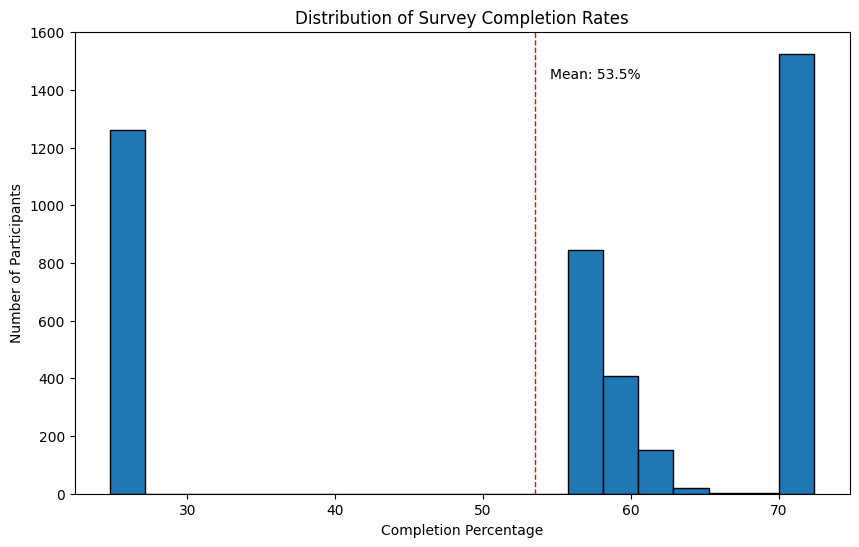

Users with less than 50% completion: 1260 (29.9% of all users)


In [380]:
questions_per_user_query = """
SELECT 
    UserID, 
    COUNT(QuestionID) as QuestionsAnswered,
    (SELECT COUNT(*) FROM Question) as TotalQuestions,
    COUNT(QuestionID) * 100.0 / (SELECT COUNT(*) FROM Question) as CompletionPercentage
FROM Answer
GROUP BY UserID
ORDER BY QuestionsAnswered DESC
"""

questions_per_user = pd.read_sql_query(questions_per_user_query, conn)
display(questions_per_user.head(5))

print("Summary of question answered per participant:")
display(questions_per_user['QuestionsAnswered'].describe())

plt.figure(figsize=(10, 6))
plt.hist(questions_per_user['CompletionPercentage'], bins=20, edgecolor='black')
plt.title('Distribution of Survey Completion Rates')
plt.xlabel('Completion Percentage')
plt.ylabel('Number of Participants')
plt.axvline(questions_per_user['CompletionPercentage'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.text(questions_per_user['CompletionPercentage'].mean()+1, plt.ylim()[1]*0.9, f'Mean: {questions_per_user["CompletionPercentage"].mean():.1f}%')
plt.show()

low_response_users = questions_per_user[questions_per_user['CompletionPercentage'] < 50]
print(f"Users with less than 50% completion: {len(low_response_users)} ({len(low_response_users)*100/len(questions_per_user):.1f}% of all users)")

**Observation:**

Looking at the completion rates by year, we can see a very clear pattern:

* **2014 Survey:** 1,260 participants, but they only answered 26 questions on average
* **2016 Survey:** 1,433 participants, answering an average of ~62 questions
* **2017-2019 Surveys:** All participants answered exactly 76 questions each year

This strongly suggests that the surveys had different structures across years:

* The 2014 survey likely had a shorter questionnaire with only 26 questions
* The 2016 survey had an expanded questionnaire with ~62 questions
* The 2017-2019 surveys were standardized with exactly 76 questions

This explains why no participant answered all 105 questions - no single survey year contained all 105 questions. Different questions were likely asked in different years.

### **<ins>1.4. Explore the Questions</ins>**

#### **1.4.1 Get all questions**

In [381]:
pd.set_option('display.max_colwidth', None)

questions_query = """
SELECT questionid, questiontext
FROM Question
ORDER BY questionid;
"""
all_questions = pd.read_sql_query(questions_query, conn)
display(all_questions.iloc[0:10])

,questionid,questiontext
0,1,What is your age?
1,2,What is your gender?
2,3,What country do you live in?
3,4,"If you live in the United States, which state or territory do you live in?"
4,5,Are you self-employed?
5,6,Do you have a family history of mental illness?
6,7,Have you ever sought treatment for a mental health disorder from a mental health professional?
7,8,How many employees does your company or organization have?
8,9,Is your employer primarily a tech company/organization?
9,10,Does your employer provide mental health benefits as part of healthcare coverage?


There are a **total of 105 questions (rows)** with **QuestionIDs ranging from 1-34 and 48-118.**

#### **1.4.2 Identify Mental Health Related Questions**

In [382]:
mental_health_query = """
SELECT questionid, questiontext
FROM Question
WHERE lower(questiontext) LIKE '%depress%' 
   OR lower(questiontext) LIKE '%anxi%' 
   OR lower(questiontext) LIKE '%mental%'
   OR lower(questiontext) LIKE '%ill%'
   OR lower(questiontext) LIKE '%disorder%'
   OR lower(questiontext) LIKE '%condition%'
   OR lower(questiontext) LIKE '%health%'
   OR lower(questiontext) LIKE '%treatment%';
"""
mental_health_questions = pd.read_sql_query(mental_health_query, conn)
display(mental_health_questions.iloc[0:10])

,questionid,questiontext
0,6,Do you have a family history of mental illness?
1,7,Have you ever sought treatment for a mental health disorder from a mental health professional?
2,10,Does your employer provide mental health benefits as part of healthcare coverage?
3,11,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
4,12,Would you bring up a mental health issue with a potential employer in an interview?
5,14,Do you know the options for mental health care available under your employer-provided health coverage?
6,15,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?"
7,16,Does your employer offer resources to learn more about mental health disorders and options for seeking help?
8,17,"If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?"
9,18,Would you feel comfortable discussing a mental health issue with your coworkers?


There are **84 questions related to 'mental health'.** The questions can be inspected by using indexing (.iloc[]) and looking at a certain range of questions for better inspection.

#### **1.4.3 Identify which mental health questions appear in which surveys via Wildcards**

In [383]:
mental_health_by_year_query = """
SELECT 
    q.questionid,
    q.questiontext,
    a.SurveyID as Year,
    COUNT(DISTINCT a.UserID) as Respondents
FROM 
    Question q
JOIN 
    Answer a ON q.questionid = a.QuestionID
WHERE 
    lower(q.questiontext) LIKE '%depress%' 
    OR lower(q.questiontext) LIKE '%anxi%' 
    OR lower(q.questiontext) LIKE '%mental%'
    OR lower(q.questiontext) LIKE '%disorder%'
    OR lower(q.questiontext) LIKE '%ill%'
    OR lower(q.questiontext) LIKE '%condition%'
    OR lower(q.questiontext) LIKE '%health%'
    OR lower(q.questiontext) LIKE '%treatment%'
GROUP BY 
    q.questionid, a.SurveyID
ORDER BY 
    q.questionid, a.SurveyID
"""
pd.set_option('display.max_colwidth', None)

mental_health_by_year = pd.read_sql_query(mental_health_by_year_query, conn)
display(mental_health_by_year.iloc[0:20])

,questionid,questiontext,Year,Respondents
0,6,Do you have a family history of mental illness?,2014,1260
1,6,Do you have a family history of mental illness?,2016,1433
2,6,Do you have a family history of mental illness?,2017,756
3,6,Do you have a family history of mental illness?,2018,417
4,6,Do you have a family history of mental illness?,2019,352
5,7,Have you ever sought treatment for a mental health disorder from a mental health professional?,2014,1260
6,7,Have you ever sought treatment for a mental health disorder from a mental health professional?,2016,1433
7,7,Have you ever sought treatment for a mental health disorder from a mental health professional?,2017,756
8,7,Have you ever sought treatment for a mental health disorder from a mental health professional?,2018,417
9,7,Have you ever sought treatment for a mental health disorder from a mental health professional?,2019,352


### **<ins>1.5 Sociodemographic Feature Analysis</ins>**

Next, all survey data from all years is used to get an understanding of the sociodemographic features. Refer to 1.4.1 where all questions (105 total) can be inspected and displayed and where sociodemographic features where chosen from.

Sociodemographic features analysis using the following QuestionIDs:

* Age (QuestionID = 1)
* Gender (QuestionID = 2)
* Geographic location (country, state; QuestionID = 3)
* Employment status (self-employed, employed; QuestionID = 5)
* Job role/position and sector - tech vs non-tech (QuestionID = 9)
* Company size (QuestionID = 8)
* Race/ethnicity (QuestionID = 89)

#### **1.5.1 Age distribution** 

In [105]:
age_query = """
SELECT 
    AnswerText as Age, 
    COUNT(*) as Frequency
FROM Answer
WHERE QuestionID = 1  -- QuestionID 1 is age based on our earlier exploration
GROUP BY AnswerText
ORDER BY Frequency DESC
"""

age_values = pd.read_sql_query(age_query, conn)
display(age_values.iloc[0:10])

,Age,Frequency
0,30,250
1,29,229
2,32,227
3,31,223
4,28,220
5,34,202
6,35,201
7,33,201
8,27,197
9,26,194


,AgeGroup,Frequency,Percentage
0,18-24,394,9.4
1,25-29,987,23.5
2,30-34,1103,26.2
3,35-39,829,19.7
4,40-49,695,16.5
5,50-64,184,4.4
6,65+,11,0.3


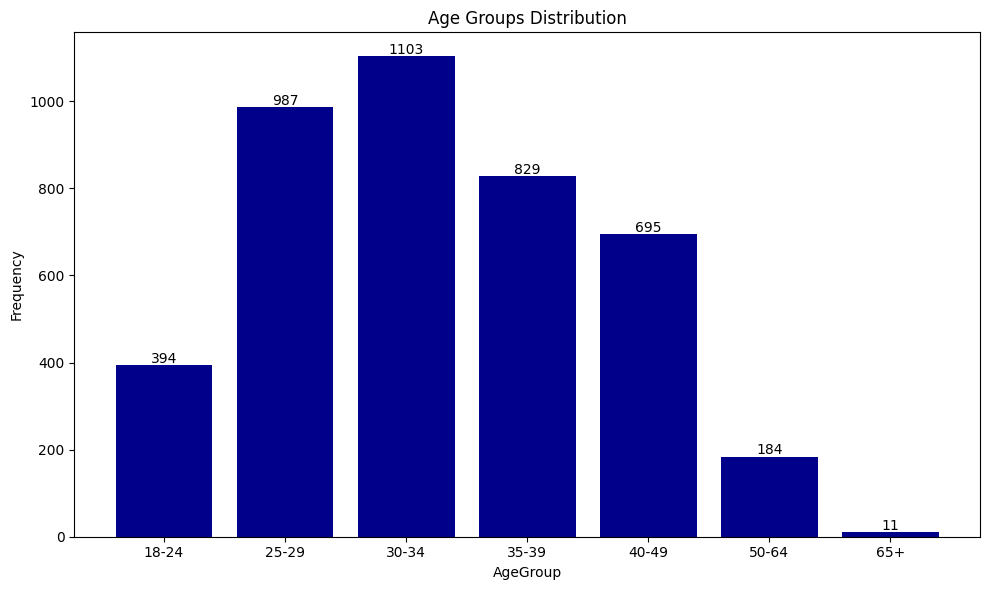

In [363]:
age_groups_query = """
SELECT 
    CASE 
        WHEN CAST(AnswerText AS INTEGER) BETWEEN 18 AND 24 THEN '18-24'
        WHEN CAST(AnswerText AS INTEGER) BETWEEN 25 AND 29 THEN '25-29'
        WHEN CAST(AnswerText AS INTEGER) BETWEEN 30 AND 34 THEN '30-34'
        WHEN CAST(AnswerText AS INTEGER) BETWEEN 35 AND 39 THEN '35-39'
        WHEN CAST(AnswerText AS INTEGER) BETWEEN 40 AND 49 THEN '40-49'
        WHEN CAST(AnswerText AS INTEGER) BETWEEN 50 AND 64 THEN '50-64'
        WHEN CAST(AnswerText AS INTEGER) BETWEEN 65 AND 100 THEN '65+'
    END as AgeGroup,
    COUNT(*) as Frequency
FROM Answer
WHERE 
    QuestionID = 1
    AND CAST(AnswerText AS INTEGER) BETWEEN 18 AND 100
GROUP BY AgeGroup
ORDER BY AgeGroup
"""

age_groups = pd.read_sql_query(age_groups_query, conn)

total_respondents = age_groups['Frequency'].sum()
age_groups['Percentage'] = (age_groups['Frequency'] / total_respondents * 100).round(1)

display(age_groups)
viz.plot_bar_age_groups(age_groups)

* The largest age group is 30-34 years old (1,103 respondents), followed closely by 25-29 (987 respondents), representing the core of the tech workforce in this survey.
* There's a gradual decline in representation as age increases beyond 35, with significant drops after age 50, where only 184 respondents are in the 50-64 group and a mere 11 respondents are 65+.
* The 18-24 age group (394 respondents) shows lower representation, likely reflecting entry-level professionals just beginning their tech careers.
* Overall, approximately 69% of respondents fall between 25-39 years old, indicating a relatively young workforce typical of the tech industry.

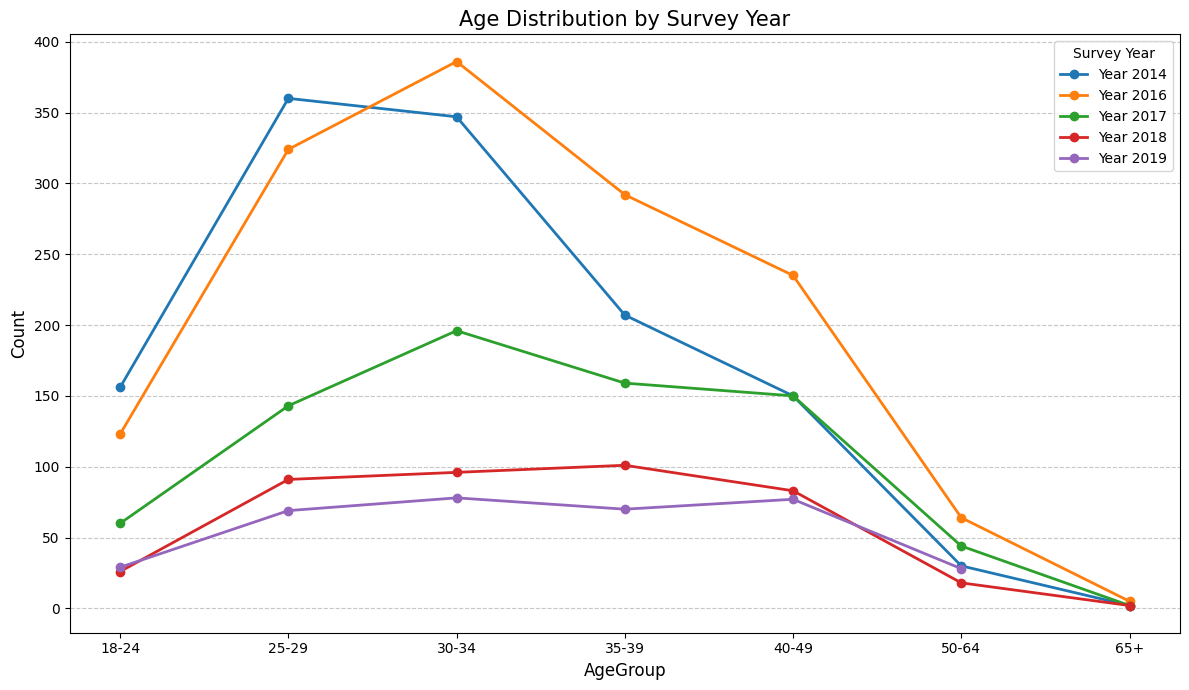

In [364]:
age_by_year_query = """
SELECT 
    a.SurveyID,
    CASE 
        WHEN CAST(a.AnswerText AS INTEGER) BETWEEN 18 AND 24 THEN '18-24'
        WHEN CAST(a.AnswerText AS INTEGER) BETWEEN 25 AND 29 THEN '25-29'
        WHEN CAST(a.AnswerText AS INTEGER) BETWEEN 30 AND 34 THEN '30-34'
        WHEN CAST(a.AnswerText AS INTEGER) BETWEEN 35 AND 39 THEN '35-39'
        WHEN CAST(a.AnswerText AS INTEGER) BETWEEN 40 AND 49 THEN '40-49'
        WHEN CAST(a.AnswerText AS INTEGER) BETWEEN 50 AND 64 THEN '50-64'
        WHEN CAST(a.AnswerText AS INTEGER) BETWEEN 65 AND 100 THEN '65+'
    END as AgeGroup,
    COUNT(*) as Count
FROM Answer a
WHERE 
    a.QuestionID = 1
    AND CAST(a.AnswerText AS INTEGER) BETWEEN 18 AND 100
GROUP BY a.SurveyID, AgeGroup
ORDER BY a.SurveyID, AgeGroup
"""

age_by_year = pd.read_sql_query(age_by_year_query, conn)
viz.plot_line_age_by_year(age_by_year)

* The survey was conducted over multiple years (2014-2019), with 2014 and 2016 showing the highest overall participation rates.
* Participation has generally decreased in more recent years (2017-2019), possibly indicating survey fatigue or changes in recruitment methods.
* The age distribution pattern remains relatively consistent across years, maintaining the bell curve shape with peak participation in the 25-34 range.
* The smallest participation gap between years is seen in the youngest (18-24) and oldest (65+) categories, suggesting these groups have more stable, though lower, representation rates.

#### **1.5.2 Gender distribution** 

Examine first the appearance of unique value to get a grasp of the data before plotting:

In [205]:
gender_query = """
SELECT 
    AnswerText as Gender, 
    COUNT(*) as Frequency
FROM Answer
WHERE QuestionID = 2 
GROUP BY Gender
ORDER BY Frequency DESC
"""
gender_values = pd.read_sql_query(gender_query, conn)

unique_count = len(gender_values)
total_responses = gender_values['Frequency'].sum()

print(f"Total unique gender responses: {unique_count}")
print(f"Total respondents who answered gender question: {total_responses}")

display(gender_values.iloc[0:10])

Total unique gender responses: 101
Total respondents who answered gender question: 4218


,Gender,Frequency
0,Male,2830
1,Female,914
2,male,212
3,female,110
4,-1,24
5,Nonbinary,8
6,non-binary,6
7,Genderqueer,4
8,Agender,4
9,None,3


**Standardize gender categories:**

,StandardizedGender,Frequency,Percentage
0,Male,3053,72.4
1,Female,1029,24.4
2,Other,33,0.8
3,Non-binary,29,0.7
4,Prefer Not to Say,25,0.6
5,Transgender,17,0.4
6,Genderqueer,12,0.3
7,Agender,11,0.3
8,Genderfluid,9,0.2


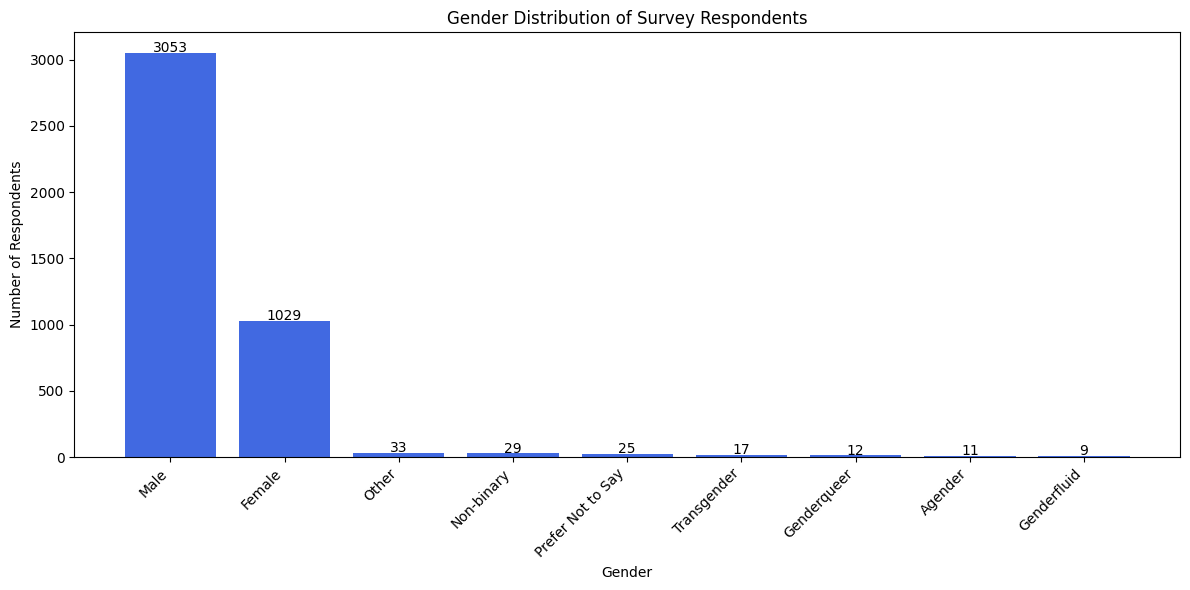

In [365]:
standardized_gender_query = """
SELECT 
    CASE 
        WHEN LOWER(TRIM(AnswerText)) IN ('male', 'm', 'male-ish', 'maile', 'male (cis)', 'cishet male', 'cis male', 
                                         'man', 'msle', 'male leaning androgynous', 'male 9:1 female, roughly',
                                         'masculino', 'ostensibly male', 'male (or female, or both)', 'masculine', 'male/androgynous') 
            THEN 'Male'
        WHEN LOWER(TRIM(AnswerText)) IN ('female', 'f', 'woman', 'female (cis)', 'cis female', 'cis woman', 
                                         'female-ish', 'female/gender non-binary', 'female-identified',
                                         'female or multi-gender femme', 'woman-identified', 'femmina') 
            THEN 'Female'
        WHEN LOWER(TRIM(AnswerText)) LIKE '%non-binary%' OR LOWER(TRIM(AnswerText)) LIKE '%nonbinary%' 
             OR LOWER(TRIM(AnswerText)) IN ('enby', 'nb', 'non binary') 
            THEN 'Non-binary'
        WHEN LOWER(TRIM(AnswerText)) LIKE '%trans%' OR LOWER(TRIM(AnswerText)) IN ('mtf', 'transfeminine', 'transgender') 
            THEN 'Transgender'
        WHEN LOWER(TRIM(AnswerText)) LIKE '%fluid%' OR LOWER(TRIM(AnswerText)) LIKE '%flux%' OR LOWER(TRIM(AnswerText)) = 'genderfluid' 
            THEN 'Genderfluid'
        WHEN LOWER(TRIM(AnswerText)) LIKE '%queer%' OR LOWER(TRIM(AnswerText)) = 'genderqueer' 
            THEN 'Genderqueer'
        WHEN LOWER(TRIM(AnswerText)) IN ('agender', 'neuter', 'none') 
            THEN 'Agender'
        WHEN LOWER(TRIM(AnswerText)) = '-1' OR LOWER(TRIM(AnswerText)) = 'prefer not to say' 
             OR LOWER(TRIM(AnswerText)) LIKE '%none of your business%' 
            THEN 'Prefer Not to Say'
        ELSE 'Other'
    END as StandardizedGender,
    COUNT(*) as Frequency
FROM Answer
WHERE QuestionID = 2
GROUP BY StandardizedGender
ORDER BY Frequency DESC
"""

standardized_gender = pd.read_sql_query(standardized_gender_query, conn)

total_respondents = standardized_gender['Frequency'].sum()
standardized_gender['Percentage'] = (standardized_gender['Frequency'] / total_respondents * 100).round(1)

display(standardized_gender)
viz.plot_bar_gender_distribution(standardized_gender)

<ins>The gender distribution bar chart highlights a significant imbalance:</ins>

* Male respondents overwhelmingly dominate the survey (3,053 respondents or approximately 73%), reflecting the persistent gender disparity in the tech industry.
* Female respondents constitute the second largest group (1,029 respondents or about 25%), but at only about one-third the number of male respondents.
* Non-binary, transgender, and other gender identities collectively represent just over 2% of respondents (136 individuals total), indicating very limited representation of gender diversity.
* 
The significant difference between male respondents and all other gender categories underscores the importance of considering gender as a potential confounding variable when analyzing mental health patterns in this dataset.

#### **1.5.3 Employment information: tech vs non-tech, self-employment status and company size** 

In [110]:
self_employed_query = """
SELECT 
    AnswerText as SelfEmployed, 
    COUNT(*) as Frequency
FROM Answer
WHERE QuestionID = 5 
GROUP BY SelfEmployed
ORDER BY Frequency DESC
"""
self_employed_values = pd.read_sql_query(self_employed_query, conn)

unique_count = len(self_employed_values)
total_responses = self_employed_values['Frequency'].sum()
print(f"Question: Are you self-employed? (QuestionID = 5)")
print(f"Total unique responses: {unique_count}")
print(f"Total respondents who answered this question: {total_responses}")
display(self_employed_values)

tech_company_query = """
SELECT 
    AnswerText as TechCompany, 
    COUNT(*) as Frequency
FROM Answer
WHERE QuestionID = 9
GROUP BY TechCompany
ORDER BY Frequency DESC
"""
tech_company_values = pd.read_sql_query(tech_company_query, conn)

unique_count = len(tech_company_values)
total_responses = tech_company_values['Frequency'].sum()
print(f"\nQuestion: Is your employer primarily a tech company/organization? (QuestionID = 9)")
print(f"Total unique responses: {unique_count}")
print(f"Total respondents who answered this question: {total_responses}")
display(tech_company_values)

company_size_query = """
SELECT 
    AnswerText as CompanySize, 
    COUNT(*) as Frequency
FROM Answer
WHERE QuestionID = 8
GROUP BY CompanySize
ORDER BY Frequency DESC
"""
company_size_values = pd.read_sql_query(company_size_query, conn)

unique_count = len(company_size_values)
total_responses = company_size_values['Frequency'].sum()
print(f"\nQuestion: How many employees does your company or organization have? (QuestionID = 8)")
print(f"Total unique responses: {unique_count}")
print(f"Total respondents who answered this question: {total_responses}")
display(company_size_values)

Question: Are you self-employed? (QuestionID = 5)
Total unique responses: 3
Total respondents who answered this question: 4218


,SelfEmployed,Frequency
0,0,3550
1,1,650
2,-1,18



Question: Is your employer primarily a tech company/organization? (QuestionID = 9)
Total unique responses: 3
Total respondents who answered this question: 4218


,TechCompany,Frequency
0,1,2888
1,0,826
2,-1,504



Question: How many employees does your company or organization have? (QuestionID = 8)
Total unique responses: 7
Total respondents who answered this question: 4218


,CompanySize,Frequency
0,More than 1000,912
1,26-100,824
2,100-500,788
3,6-25,689
4,-1,504
5,1-5,254
6,500-1000,247


**<ins>Data Standardization Steps Explanation:</ins>**

**Self-Employment Data:**

- Create a copy of the original dataset to preserve raw data
- Convert numeric codes to human-readable labels:

* '1' → 'Yes' (self-employed)
* '0' → 'No' (not self-employed)
* '-1' → 'No Response' (missing data)


This makes the visualization more intuitive and easier to interpret.

**Tech Company Data:**

- Similarly, convert numeric codes to clear text labels
- Standardize responses for consistency across visualizations:

* '1' → 'Yes' (works at tech company)
* '0' → 'No' (works at non-tech company)
* '-1' → 'No Response' (missing data)

**Company Size Data:**

* Create a logical ordering for company size categories
* Assigne numeric values (1-7) to each size category for proper sorting
* Relabel '-1' as 'No Response' for clarity
* Add a temporary 'SizeOrder' column to sort data from smallest to largest company size
* Sort the dataset by this column to ensure consistent visualization order
* Remove the temporary sorting column after ordering was complete



These standardization steps transform raw survey codes into meaningful labels and ensure consistent ordering for visualization, making the data more accessible and interpretable.

In [406]:
standardized_self_employed_query = """
WITH StandardizedSelfEmployed AS (
    SELECT 
        CASE 
            WHEN AnswerText = '1' THEN 'Yes'
            WHEN AnswerText = '0' THEN 'No'
            WHEN AnswerText = '-1' THEN 'No Response'
            ELSE AnswerText
        END as SelfEmployed,
        COUNT(*) as Frequency
    FROM Answer
    WHERE QuestionID = 5
    GROUP BY SelfEmployed
)
SELECT 
    SelfEmployed,
    Frequency,
    ROUND(Frequency * 100.0 / (SELECT SUM(Frequency) FROM StandardizedSelfEmployed), 1) as Percentage
FROM StandardizedSelfEmployed
ORDER BY 
    CASE 
        WHEN SelfEmployed = 'Yes' THEN 1
        WHEN SelfEmployed = 'No' THEN 2
        ELSE 3
    END;
"""

self_employed_standardized = pd.read_sql_query(standardized_self_employed_query, conn)
print("Self-Employment Status:")
display(self_employed_standardized)

standardized_tech_company_query = """
WITH StandardizedTechCompany AS (
    SELECT 
        CASE 
            WHEN AnswerText = '1' THEN 'Yes'
            WHEN AnswerText = '0' THEN 'No'
            WHEN AnswerText = '-1' THEN 'No Response'
            ELSE AnswerText
        END as TechCompany,
        COUNT(*) as Frequency
    FROM Answer
    WHERE QuestionID = 9
    GROUP BY TechCompany
)
SELECT 
    TechCompany,
    Frequency,
    ROUND(Frequency * 100.0 / (SELECT SUM(Frequency) FROM StandardizedTechCompany), 1) as Percentage
FROM StandardizedTechCompany
ORDER BY 
    CASE 
        WHEN TechCompany = 'Yes' THEN 1
        WHEN TechCompany = 'No' THEN 2
        ELSE 3
    END;
"""

tech_company_standardized = pd.read_sql_query(standardized_tech_company_query, conn)
print("Employer is a Tech Company:")
display(tech_company_standardized)

standardized_company_size_query = """
WITH StandardizedCompanySize AS (
    SELECT 
        CASE 
            WHEN AnswerText = '-1' THEN 'No Response'
            ELSE AnswerText
        END as CompanySize,
        COUNT(*) as Frequency
    FROM Answer
    WHERE QuestionID = 8
    GROUP BY CompanySize
)
SELECT 
    CompanySize,
    Frequency,
    ROUND(Frequency * 100.0 / (SELECT SUM(Frequency) FROM StandardizedCompanySize), 1) as Percentage
FROM StandardizedCompanySize
WHERE CompanySize != 'No Response'
ORDER BY 
    CASE 
        WHEN CompanySize = '1-5' THEN 1
        WHEN CompanySize = '6-25' THEN 2
        WHEN CompanySize = '26-100' THEN 3
        WHEN CompanySize = '100-500' THEN 4
        WHEN CompanySize = '500-1000' THEN 5
        WHEN CompanySize = 'More than 1000' THEN 6
        ELSE 7
    END;
"""

company_size_standardized = pd.read_sql_query(standardized_company_size_query, conn)
print("Company Size Distribution:")
display(company_size_standardized)

company_size_no_response_query = """
SELECT 
    COUNT(*) as Frequency,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM Answer WHERE QuestionID = 8), 1) as Percentage
FROM Answer
WHERE QuestionID = 8 AND AnswerText = '-1';
"""
company_size_no_response = pd.read_sql_query(company_size_no_response_query, conn)
print("Company Size - No Response:")
display(company_size_no_response)

Self-Employment Status:


,SelfEmployed,Frequency,Percentage
0,Yes,650,15.4
1,No,3550,84.2
2,No Response,18,0.4


Employer is a Tech Company:


,TechCompany,Frequency,Percentage
0,Yes,2888,68.5
1,No,826,19.6
2,No Response,504,11.9


Company Size Distribution:


,CompanySize,Frequency,Percentage
0,1-5,254,6.0
1,6-25,689,16.3
2,26-100,824,19.5
3,100-500,788,18.7
4,500-1000,247,5.9
5,More than 1000,912,21.6


Company Size - No Response:


,Frequency,Percentage
0,504,11.9


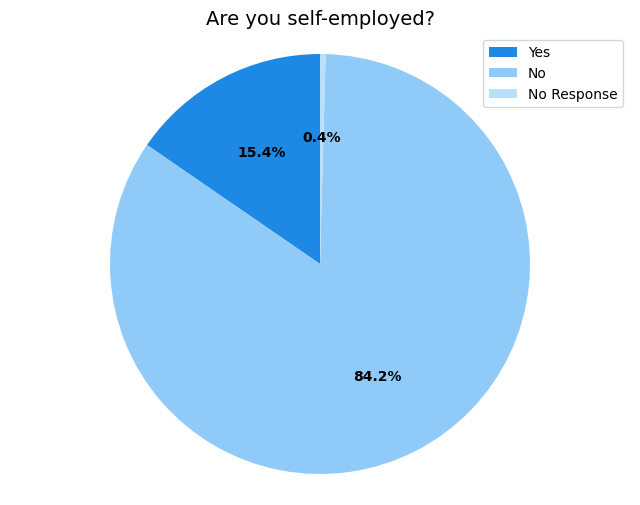

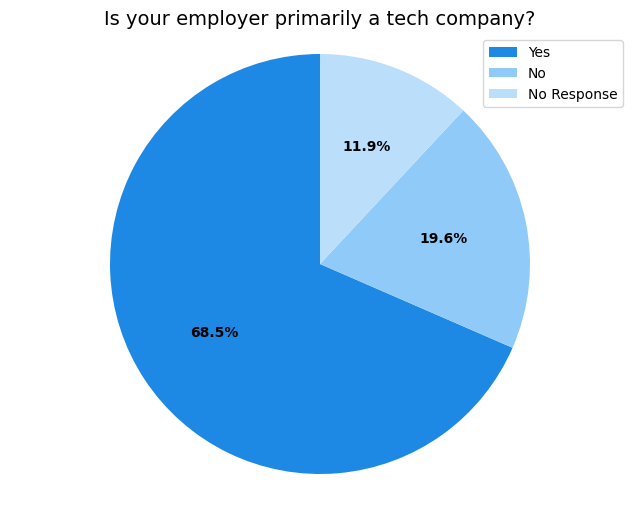

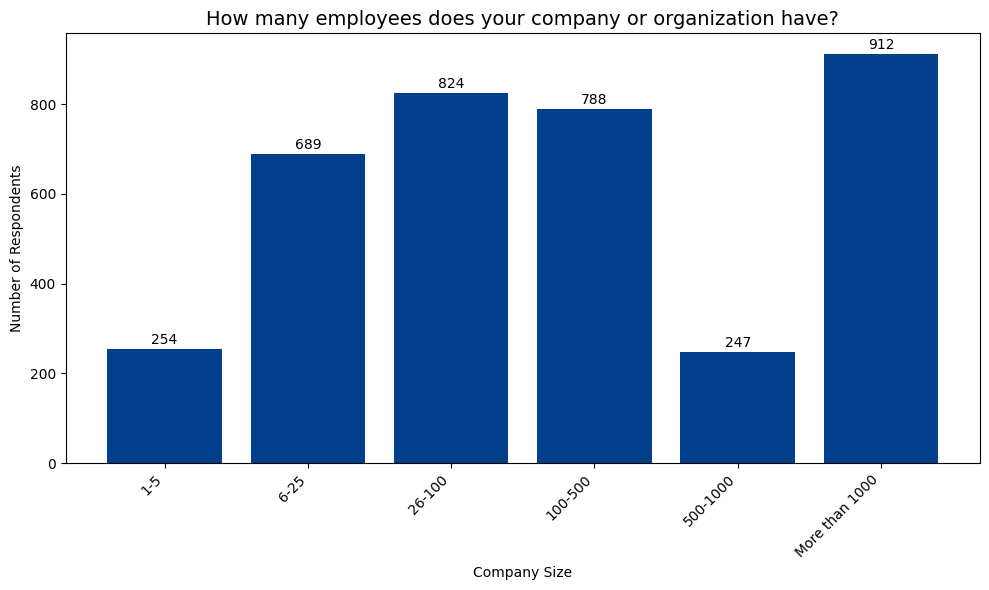

In [407]:
import importlib
import viz_utils as viz
importlib.reload(viz)

viz.plot_pie_binary_response(
    self_employed_standardized,
    'SelfEmployed',
    'Frequency',
    title='Are you self-employed?',
)

viz.plot_pie_binary_response(
    tech_company_standardized,
    'TechCompany',
    'Frequency',
    title='Is your employer primarily a tech company?',
)

viz.plot_bar_company_size(
    company_size_standardized,
    title='How many employees does your company or organization have?',
)

### **Employment Analysis Summary:**

* Predominantly **employees (84.2%)** rather than self-employed individuals (15.4%)
* Majority work in **tech companies (68.5%)** versus non-tech sectors (19.6%)
* **Company size distribution is balanced** with largest groups in:

    * Enterprises >1000 employees (21.6%)
    * Mid-sized companies 26-100 (19.5%)
   *  Companies 100-500 (18.7%)

* Small companies (6-25 employees) represent 16.3% of respondents
* **Missing data:** 11.9% did not provide company size information

#### **1.5.4 Gender distribution per sector: tech vs non-tech**

In [201]:
gender_by_tech_query = """
WITH StandardizedData AS (
    SELECT 
        a1.UserID,
        -- Standardize gender
        CASE 
            WHEN a1.AnswerText IN ('male', 'Male', 'm', 'M', 'man', 'Man', 'cis male', 'Cis Male') THEN 'Male'
            WHEN a1.AnswerText IN ('female', 'Female', 'f', 'F', 'woman', 'Woman', 'cis female', 'Cis Female') THEN 'Female'
            WHEN a1.AnswerText = '-1' THEN 'No Response'
            ELSE 'Other'
        END as Gender,
        
        -- Standardize tech company
        CASE 
            WHEN a2.AnswerText = '1' THEN 'Tech'
            WHEN a2.AnswerText = '0' THEN 'Non-Tech'
            WHEN a2.AnswerText = '-1' THEN 'No Response'
            ELSE 'Unknown'
        END as CompanyType,
        
        -- Include survey year
        a1.SurveyID as Year
    FROM 
        Answer a1
    JOIN 
        Answer a2 ON a1.UserID = a2.UserID AND a1.SurveyID = a2.SurveyID
    WHERE 
        a1.QuestionID = 2 AND a2.QuestionID = 9
)
SELECT 
    Gender,
    CompanyType,
    Year,
    COUNT(*) as Count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY CompanyType, Year), 1) as Percentage
FROM 
    StandardizedData
WHERE 
    Gender != 'No Response' AND CompanyType != 'No Response'
GROUP BY 
    Gender, CompanyType, Year
ORDER BY 
    Year, CompanyType, 
    CASE 
        WHEN Gender = 'Male' THEN 1
        WHEN Gender = 'Female' THEN 2
        ELSE 3
    END
"""

gender_tech_data = pd.read_sql_query(gender_by_tech_query, conn)
display(gender_tech_data)

,Gender,CompanyType,Year,Count,Percentage
0,Male,Non-Tech,2014,165,72.1
1,Female,Non-Tech,2014,59,25.8
2,Other,Non-Tech,2014,5,2.2
3,Male,Tech,2014,826,80.1
4,Female,Tech,2014,188,18.2
5,Other,Tech,2014,17,1.6
6,Male,Non-Tech,2016,188,72.0
7,Female,Non-Tech,2016,69,26.4
8,Other,Non-Tech,2016,4,1.5
9,Male,Tech,2016,658,74.6


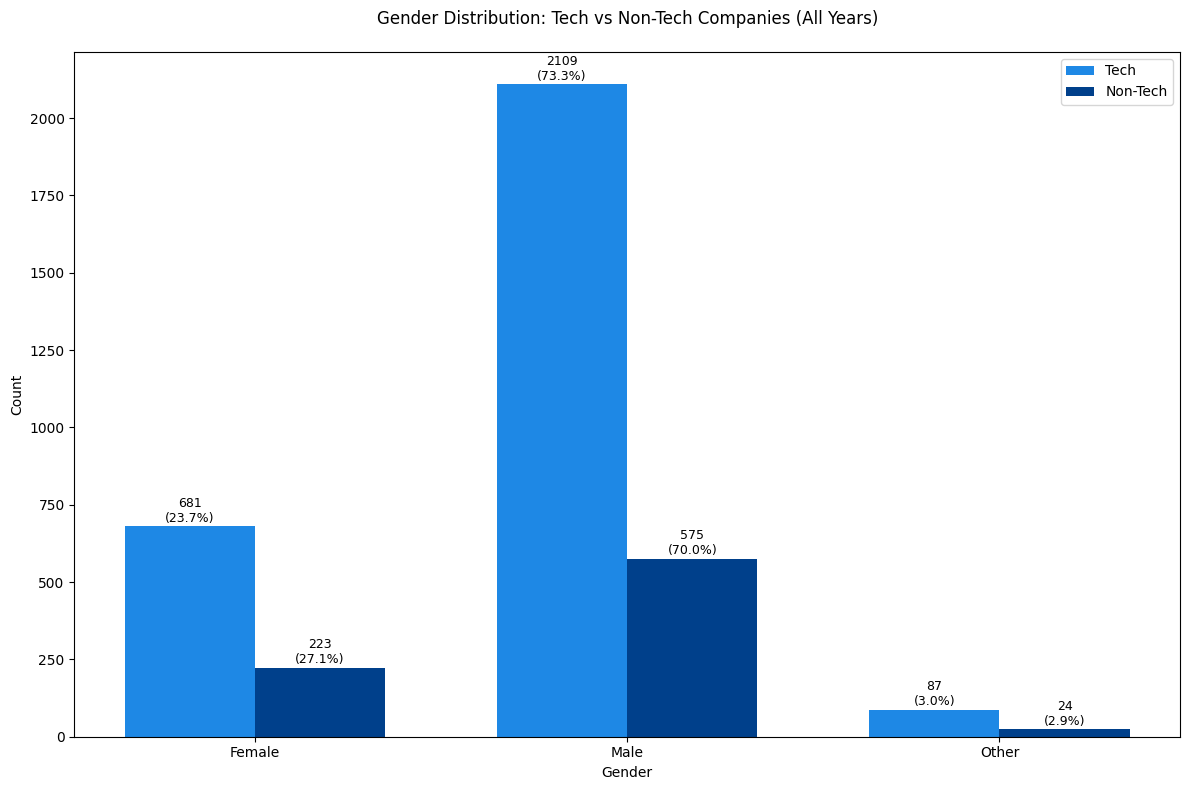

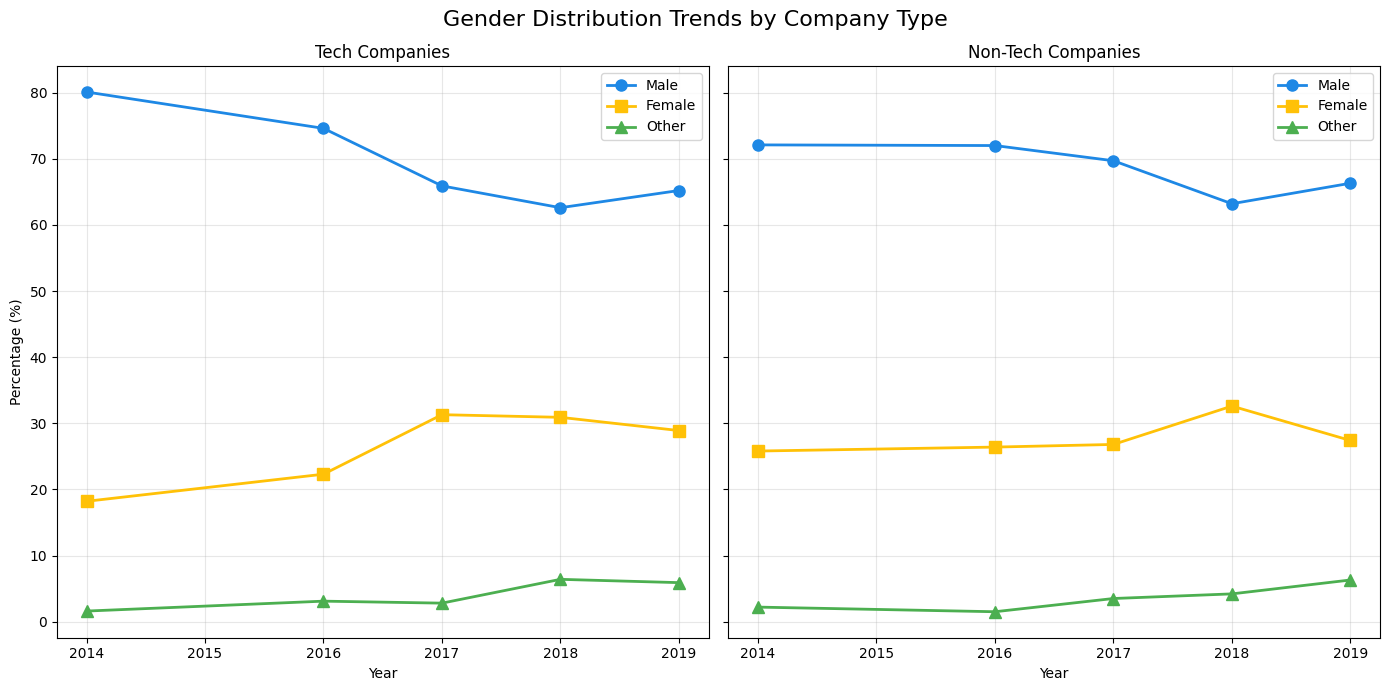

In [209]:
import importlib
import viz_utils as viz
importlib.reload(viz)

viz.plot_gender_by_tech(
    gender_tech_data
)

viz.plot_gender_trends(
    gender_tech_data
)

### **Observatins:**

**Tech companies show greater gender diversity improvement over time:**

* Male representation decreased from 80.1% (2014) to 65.2% (2019)
* Female representation increased from 18.2% (2014) to 28.9% (2019)
* "Other" gender identities increased from 1.6% to 5.9%


**Non-tech companies started with better gender balance:**

* Non-tech consistently had lower male representation than tech companies until 2018
* Female representation in non-tech remained relatively stable (25.8% to 27.4%)
* By 2019, tech companies nearly closed the gender gap with non-tech companies


**Both sectors show increasing representation of gender diversity:**

* "Other" gender identities more than tripled in both sectors from 2014 to 2019
* Tech companies saw larger growth in these identities (1.6% to 5.9%)
* Non-tech companies reached 6.3% representation of "Other" gender identities by 2019


**Convergence trend:**

* Gender distribution between tech and non-tech companies has converged over time
* By 2019, tech (65.2% male) and non-tech (66.3% male) show similar gender distributions


#### **1.5.5 Demographic Distribution: Country and State (US)** 

In [187]:
country_query = """
SELECT 
    AnswerText as Country, 
    COUNT(*) as Frequency
FROM Answer
WHERE QuestionID = 3
GROUP BY Country
ORDER BY Frequency DESC
"""
country_values = pd.read_sql_query(country_query, conn)

unique_count = len(country_values)
total_responses = country_values['Frequency'].sum()
print(f"Question: What country do you live in? (QuestionID = 3)")
print(f"Total unique country responses: {unique_count}")
print(f"Total respondents who answered this question: {total_responses}")
display(country_values.iloc[0:10])

state_query = """
SELECT 
    AnswerText as State, 
    COUNT(*) as Frequency
FROM Answer
WHERE QuestionID = 4
GROUP BY State
ORDER BY Frequency DESC
"""
state_values = pd.read_sql_query(state_query, conn)

unique_count = len(state_values)
total_responses = state_values['Frequency'].sum()
print(f"\nQuestion: If you live in the United States, which state or territory? (QuestionID = 4)")
print(f"Total unique state responses: {unique_count}")
print(f"Total respondents who answered this question: {total_responses}")
display(state_values.iloc[0:10])

Question: What country do you live in? (QuestionID = 3)
Total unique country responses: 81
Total respondents who answered this question: 4218


,Country,Frequency
0,United States of America,1853
1,United States,751
2,United Kingdom,482
3,Canada,199
4,Germany,136
5,Netherlands,98
6,Australia,73
7,Ireland,51
8,France,51
9,India,50



Question: If you live in the United States, which state or territory? (QuestionID = 4)
Total unique state responses: 51
Total respondents who answered this question: 4218


,State,Frequency
0,-1,1622
1,California,382
2,Illinois,223
3,Washington,168
4,New York,146
5,Tennessee,121
6,Texas,119
7,Ohio,109
8,Michigan,108
9,Minnesota,101


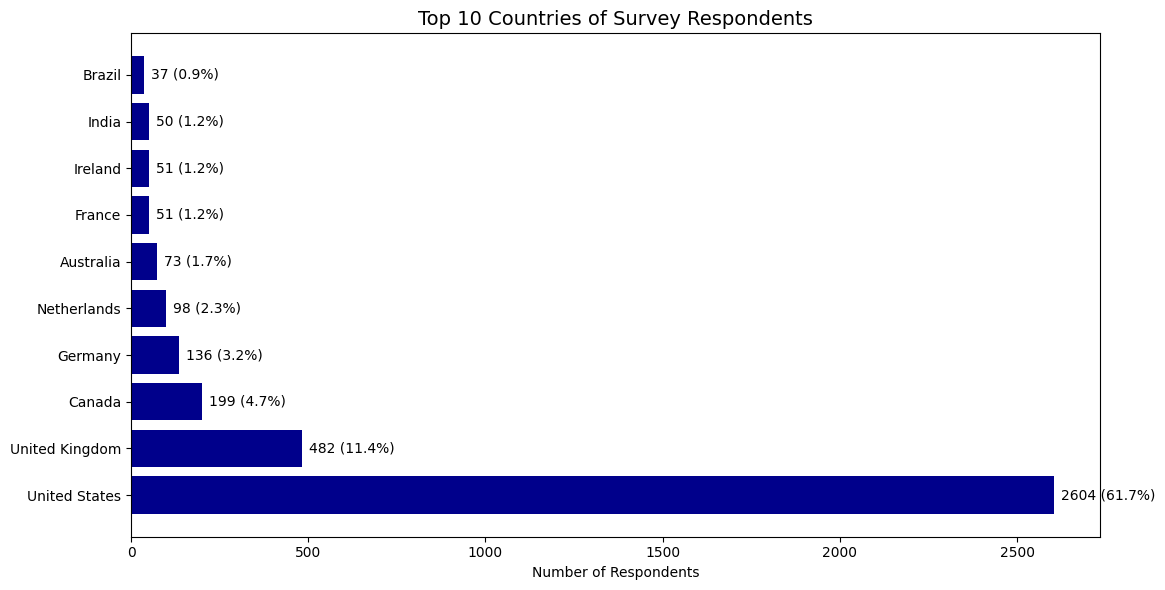

In [275]:
standardized_country_query = """
WITH StandardizedCountries AS (
    SELECT 
        CASE 
            WHEN AnswerText IN ('United States of America', 'USA', 'US', 'U.S.', 'U.S') THEN 'United States'
            WHEN AnswerText = '-1' THEN 'No Response'
            ELSE AnswerText
        END as Country,
        COUNT(*) as Frequency
    FROM Answer
    WHERE QuestionID = 3
    GROUP BY Country
)
SELECT 
    Country,
    Frequency,
    ROUND(Frequency * 100.0 / (SELECT SUM(Frequency) FROM StandardizedCountries), 1) as Percentage
FROM StandardizedCountries
WHERE Country NOT IN ('No Response')
ORDER BY Frequency DESC
LIMIT 10;
"""

top_countries = pd.read_sql_query(standardized_country_query, conn)

viz.plot_top_countries(
    top_countries,
    title='Top 10 Countries of Survey Respondents'
)

### **Geographic Distribution of Survey Respondents:**

* **Strong US dominance:** 61.7% of all respondents (2,604 individuals) are from the United States
* **English-speaking countries lead:** Top 3 countries (US, UK, Canada) account for 77.8% of all responses
* **Limited global diversity:** Only 10 countries have 50+ respondents each
* **European representation:** UK (11.4%), Germany (3.2%), Netherlands (2.3%), Ireland and France (1.2% each)
* **Minimal representation from Asia, South America and Africa:** India (1.2%) and Brazil (0.9%) are the only non-Western countries in the top 10

**US State Distribution:**

* **Tech hubs dominate:** California leads with 382 respondents, followed by Illinois (223) and Washington (168)
* **Geographic spread:** All US states represented, with strong participation from both coasts and the Midwest
* **Notable concentration:** The top 9 states account for over 34% of US respondents
* **Missing responses:** 1,622 respondents did not specify their state, limiting complete geographic analysis

#### **1.5.6 Race/Ethnicity Distribution**

In [276]:
race_query = """
SELECT 
    AnswerText as Race, 
    COUNT(*) as Frequency
FROM Answer
WHERE QuestionID = 89
GROUP BY Race
ORDER BY Frequency DESC
"""
race_values = pd.read_sql_query(race_query, conn)

unique_count = len(race_values)
total_responses = race_values['Frequency'].sum()
print(f"Question: What is your race? (QuestionID = 89)")
print(f"Total unique race/ethnicity responses: {unique_count}")
print(f"Total respondents who answered this question: {total_responses}")
display(race_values)

Question: What is your race? (QuestionID = 89)
Total unique race/ethnicity responses: 11
Total respondents who answered this question: 1525


,Race,Frequency
0,White,873
1,-1,537
2,More than one of the above,35
3,Asian,31
4,I prefer not to answer,29
5,Black or African American,15
6,White Hispanic,1
7,Hispanic,1
8,European American,1
9,Caucasian,1


Race/Ethnicity Distribution:


,Race,Frequency,Percentage
0,White,875,88.6
1,Multiracial,35,3.5
2,Asian,31,3.1
3,Prefer not to answer,29,2.9
4,Black or African American,15,1.5
5,Hispanic,2,0.2
6,American Indian or Alaska Native,1,0.1


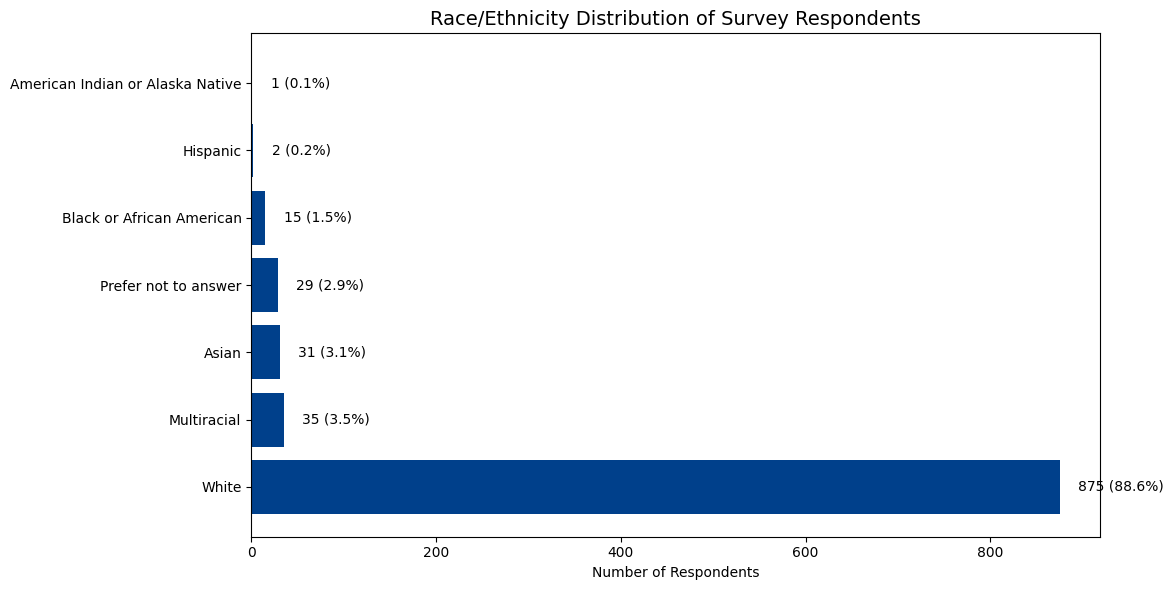

In [277]:
standardized_race_query = """
WITH StandardizedRace AS (
    SELECT 
        CASE 
            -- Only standardize equivalent terms, keep original designations for distinct groups
            WHEN AnswerText IN ('White', 'Caucasian', 'European American') THEN 'White'
            WHEN AnswerText IN ('Hispanic', 'White Hispanic') THEN 'Hispanic'
            WHEN AnswerText = 'Black or African American' THEN 'Black or African American'
            WHEN AnswerText = 'Asian' THEN 'Asian'
            WHEN AnswerText = 'American Indian or Alaska Native' THEN 'American Indian or Alaska Native'
            WHEN AnswerText = 'More than one of the above' THEN 'Multiracial'
            WHEN AnswerText = 'I prefer not to answer' THEN 'Prefer not to answer'
            WHEN AnswerText = '-1' THEN 'No Response'
            ELSE AnswerText
        END as Race,
        COUNT(*) as Frequency
    FROM Answer
    WHERE QuestionID = 89
    GROUP BY Race
)
SELECT 
    Race,
    Frequency,
    ROUND(Frequency * 100.0 / (SELECT SUM(Frequency) FROM StandardizedRace WHERE Race NOT IN ('No Response')), 1) as Percentage
FROM StandardizedRace
WHERE Race NOT IN ('No Response')
ORDER BY Frequency DESC
"""

race_data = pd.read_sql_query(standardized_race_query, conn)
print("Race/Ethnicity Distribution:")
display(race_data)

import importlib
import viz_utils as viz
importlib.reload(viz)

viz.plot_top_countries(
    race_data,
    country_column='Race',  
    count_column='Frequency',  
    percentage_column='Percentage', 
    title='Race/Ethnicity Distribution of Survey Respondents',
    color='#00408B' 
)

### **Race/Ethnicity Distribution Summary:**

* **Overwhelmingly White:** 88.6% of respondents identify as White
* **Minimal diversity:** Only 4.8% combined Black, Asian, and Hispanic representation
* **Underrepresentation:** Black/African American (1.5%) and Hispanic (0.2%) populations severely underrepresented
* **Data limitations:** This lack of racial diversity significantly limits the applicability of findings to non-White tech workers
* **Missing perspectives:** Native American respondents are basically absent (0.1%)

### **1.5.6 Summary and Findings**

**Potential Sampling Biases:**

* **Gender Distribution Bias:** The dataset shows a significant underrepresentation of women compared to the tech industry average. While the tech industry generally has gender imbalance (around 25-30% women), the data sample may show an even more pronounced skew toward male respondents.
* **Age Bias:** The age distribution of the surveys may not match the broader tech workforce. Tech workers tend to skew younger, but your sample may over-represent certain age groups (often mid-career professionals) while under-representing others (especially older workers).
* **Geographic Bias:** Based on the country analysis, there's significant overrepresentation of US-based respondents compared to the global tech workforce distribution. This limits the generalizability of findings to other regions with different healthcare systems and workplace cultures.
* **Self-Selection Bias:** People with personal experience or interest in mental health issues are more likely to participate in mental health surveys, potentially inflating prevalence rates compared to the general tech population.
* **Response Bias:** Questions about sensitive topics like mental health are subject to social desirability bias, where respondents may underreport stigmatized conditions or overreport treatment-seeking behavior.
* **Survivor Bias:** The survey only captures people currently in the tech industry, potentially missing those who left due to mental health challenges (potentially the most severe cases).
* **Company Size Bias:** The analysis may show overrepresentation of workers from larger tech companies, which typically have more resources for mental health support compared to smaller companies or startups.

### **<ins>1.6 Mental Health Prevalence Analysis</ins>**

In [366]:
mental_health_by_year_query = """
SELECT 
    a.SurveyID as Year,
    MAX(CASE WHEN a.QuestionID = 32 THEN a.AnswerText END) as PastDisorder,
    MAX(CASE WHEN a.QuestionID = 33 THEN a.AnswerText END) as CurrentDisorder,
    MAX(CASE WHEN a.QuestionID = 34 THEN a.AnswerText END) as DiagnosedDisorder,
    COUNT(*) as Count
FROM Answer a
GROUP BY a.UserID, a.SurveyID
"""

mh_by_year = pd.read_sql_query(mental_health_by_year_query, conn)

print("Mental Health Status Overview (All Years):")
print(f"Total respondents: {len(mh_by_year)}")
print(f"Past Disorder - Yes: {(mh_by_year['PastDisorder'] == 'Yes').sum()} ({(mh_by_year['PastDisorder'] == 'Yes').mean()*100:.1f}%)")
print(f"Current Disorder - Yes: {(mh_by_year['CurrentDisorder'] == 'Yes').sum()} ({(mh_by_year['CurrentDisorder'] == 'Yes').mean()*100:.1f}%)")
print(f"Diagnosed Disorder - Yes: {(mh_by_year['DiagnosedDisorder'] == 'Yes').sum()} ({(mh_by_year['DiagnosedDisorder'] == 'Yes').mean()*100:.1f}%)")

print("\nMental Health Status by Year:")
yearly_summary = []

for year in sorted(mh_by_year['Year'].unique()):
    year_data = mh_by_year[mh_by_year['Year'] == year]
    
    yearly_summary.append({
        'Year': year,
        'Total Respondents': len(year_data),
        'Past Disorder (%)': (year_data['PastDisorder'] == 'Yes').mean() * 100,
        'Current Disorder (%)': (year_data['CurrentDisorder'] == 'Yes').mean() * 100,
        'Diagnosed Disorder (%)': (year_data['DiagnosedDisorder'] == 'Yes').mean() * 100
    })

yearly_df = pd.DataFrame(yearly_summary).round(1)
display(yearly_df)

Mental Health Status Overview (All Years):
Total respondents: 4218
Past Disorder - Yes: 1417 (33.6%)
Current Disorder - Yes: 1237 (29.3%)
Diagnosed Disorder - Yes: 1363 (32.3%)

Mental Health Status by Year:


,Year,Total Respondents,Past Disorder (%),Current Disorder (%),Diagnosed Disorder (%)
0,2014,1260,0.0,0.0,0.0
1,2016,1433,51.4,40.1,50.0
2,2017,756,43.9,42.9,41.5
3,2018,417,48.7,45.8,45.3
4,2019,352,41.5,41.8,40.9


In [367]:
diagnosed_conditions_query = """
SELECT DISTINCT AnswerText
FROM Answer
WHERE QuestionID = 115 AND AnswerText != '-1'
"""
unique_conditions = pd.read_sql_query(diagnosed_conditions_query, conn)
print(f"Unique condition responses: {len(unique_conditions)}")
display(unique_conditions)

condition_frequency_query = """
SELECT 
    AnswerText as Condition,
    COUNT(*) as Frequency,
    ROUND(COUNT(*) * 100.0 / (
        SELECT COUNT(*) FROM Answer 
        WHERE QuestionID = 115 AND AnswerText != '-1'
    ), 1) as Percentage
FROM Answer
WHERE QuestionID = 115 AND AnswerText != '-1'
GROUP BY Condition
ORDER BY Frequency DESC
"""
condition_counts = pd.read_sql_query(condition_frequency_query, conn)
print(f"\nDiagnosed Condition Frequencies (Total unique conditions: {len(condition_counts)}):")
display(condition_counts)

Unique condition responses: 33


,AnswerText
0,"Anxiety Disorder (Generalized, Social, Phobia, etc)"
1,"Mood Disorder (Depression, Bipolar Disorder, etc)"
2,Stress Response Syndromes
3,Substance Use Disorder
4,Obsessive-Compulsive Disorder
5,"Eating Disorder (Anorexia, Bulimia, etc)"
6,"Personality Disorder (Borderline, Antisocial, Paranoid, etc)"
7,Attention Deficit Hyperactivity Disorder
8,Addictive Disorder
9,Post-traumatic Stress Disorder



Diagnosed Condition Frequencies (Total unique conditions: 33):


,Condition,Frequency,Percentage
0,"Mood Disorder (Depression, Bipolar Disorder, etc)",412,34.1
1,"Anxiety Disorder (Generalized, Social, Phobia, etc)",345,28.6
2,Attention Deficit Hyperactivity Disorder,121,10.0
3,Post-traumatic Stress Disorder,69,5.7
4,Obsessive-Compulsive Disorder,45,3.7
5,Substance Use Disorder,39,3.2
6,Stress Response Syndromes,38,3.1
7,"Personality Disorder (Borderline, Antisocial, Paranoid, etc)",35,2.9
8,Addictive Disorder,35,2.9
9,"Eating Disorder (Anorexia, Bulimia, etc)",28,2.3


,Condition,Count,Prevalence (%),95% CI
0,"Mood Disorder (Depression, Bipolar Disorder, etc)",412,9.8,(8.9% - 10.7%)
1,"Anxiety Disorder (Generalized, Social, Phobia, etc)",345,8.2,(7.4% - 9.0%)
2,Attention Deficit Hyperactivity Disorder,121,2.9,(2.4% - 3.4%)
3,Post-traumatic Stress Disorder,69,1.6,(1.3% - 2.0%)
4,Obsessive-Compulsive Disorder,45,1.1,(0.8% - 1.4%)


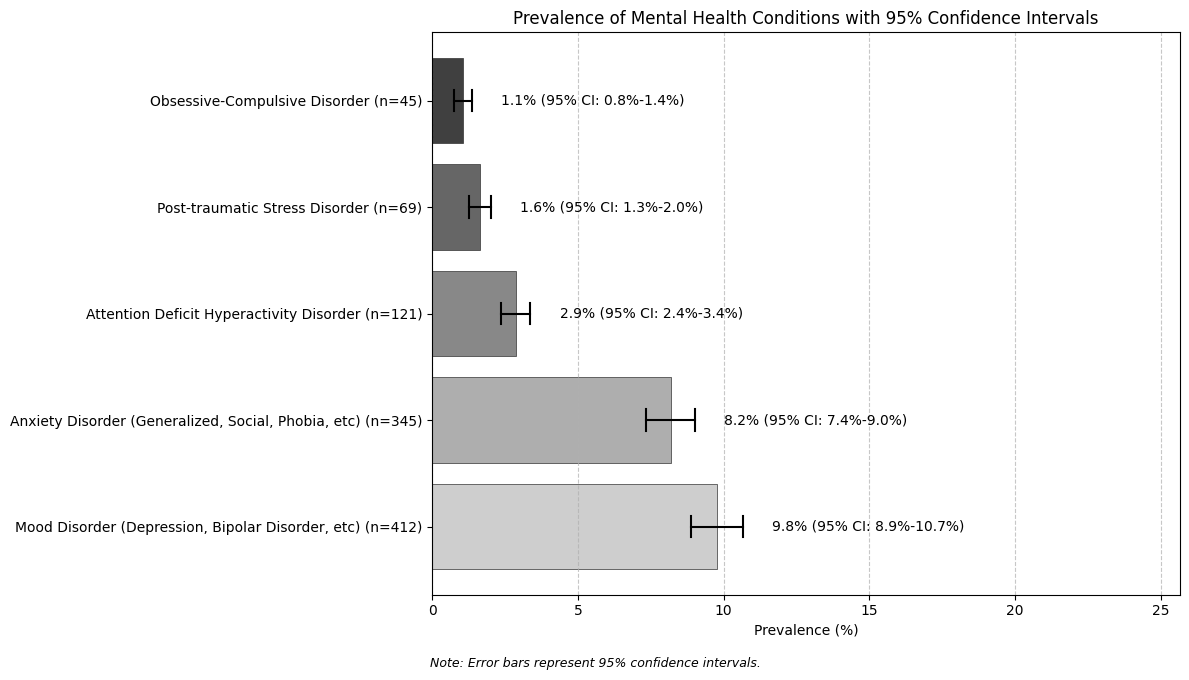

In [386]:
def calculate_prevalence(condition_row, total_respondents):
    condition = condition_row['Condition']
    condition_count = condition_row['Frequency']
    
    prevalence = condition_count / total_respondents
    
    se = np.sqrt((prevalence * (1 - prevalence)) / total_respondents)
    z = stats.norm.ppf(0.975)  # 95% CI
    ci_lower = max(0, prevalence - z * se)
    ci_upper = min(1, prevalence + z * se)
    
    return {
        'Condition': condition,
        'Count': condition_count,
        'Prevalence': prevalence,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper
    }

total_respondents = 4218 
prevalence_results = []
top_n = 5 

for _, row in condition_counts.head(top_n).iterrows():
    prevalence_results.append(calculate_prevalence(row, total_respondents))
    
prevalence_df = pd.DataFrame(prevalence_results)
prevalence_df['Prevalence (%)'] = (prevalence_df['Prevalence'] * 100).round(1)
prevalence_df['95% CI'] = prevalence_df.apply(
    lambda x: f"({(x['CI_Lower'] * 100):.1f}% - {(x['CI_Upper'] * 100):.1f}%)", axis=1
)

display(prevalence_df[['Condition', 'Count', 'Prevalence (%)', '95% CI']])

import importlib
import viz_utils as viz
importlib.reload(viz)

fig = viz.plot_prevalence_with_ci(prevalence_df)
display(fig)

### **Mental Health Conditions Prevalence Among Survey Respondents:**

* **Mood disorders most common:** Depression and bipolar disorders affect 9.8% of respondents (CI: 8.9%-10.7%)
* **Anxiety disorders prevalent:** 8.2% report anxiety conditions (CI: 7.4%-9.0%)
* **ADHD ranks third:** 2.9% of all respondents diagnosed with ADHD (CI: 2.4%-3.4%)
* **Less common conditions:** PTSD (1.6%, CI: 1.3%-2.0%) and OCD (1.1%, CI: 0.8%-1.4%)
* **Data quality:** Narrow confidence intervals indicate reliable prevalence estimates across the full dataset

**Interpretation context:** These rates represent diagnosed conditions only, suggesting actual prevalence may be higher due to undiagnosed cases

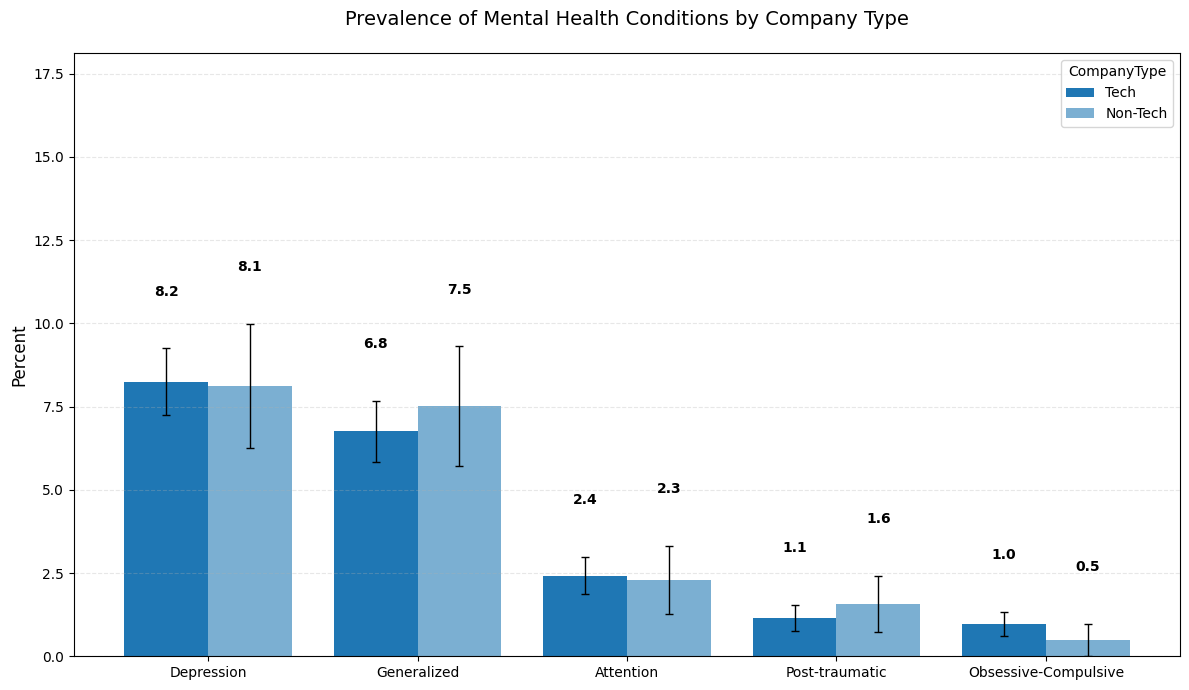

Full condition names:
Depression: Mood Disorder (Depression, Bipolar Disorder, etc)
Generalized: Anxiety Disorder (Generalized, Social, Phobia, etc)
Attention: Attention Deficit Hyperactivity Disorder
Post-traumatic: Post-traumatic Stress Disorder
Obsessive-Compulsive: Obsessive-Compulsive Disorder


In [389]:
prevalence_by_group_query = """
WITH UserInfo AS (
    SELECT 
        a1.UserID,
        MAX(CASE WHEN a1.QuestionID = 2 THEN 
            CASE 
                WHEN LOWER(a1.AnswerText) IN ('male', 'm', 'man', 'cis male') THEN 'Male'
                WHEN LOWER(a1.AnswerText) IN ('female', 'f', 'woman', 'cis female') THEN 'Female'
                ELSE 'Other'
            END
        END) as Gender,
        MAX(CASE WHEN a1.QuestionID = 9 THEN 
            CASE 
                WHEN a1.AnswerText = '1' THEN 'Tech'
                WHEN a1.AnswerText = '0' THEN 'Non-Tech'
                ELSE 'Unknown'
            END
        END) as CompanyType
    FROM Answer a1
    GROUP BY a1.UserID
),
ConditionInfo AS (
    SELECT 
        a2.UserID,
        a2.AnswerText as Condition
    FROM Answer a2
    WHERE a2.QuestionID = 115 AND a2.AnswerText != '-1'
)
SELECT 
    c.Condition,
    u.Gender,
    u.CompanyType,
    COUNT(*) as Count
FROM ConditionInfo c
JOIN UserInfo u ON c.UserID = u.UserID
WHERE u.Gender IN ('Male', 'Female') AND u.CompanyType IN ('Tech', 'Non-Tech')
GROUP BY c.Condition, u.Gender, u.CompanyType
ORDER BY c.Condition, u.Gender, u.CompanyType
"""

condition_by_group = pd.read_sql_query(prevalence_by_group_query, conn)

def calculate_group_prevalence(condition, group_col, group_val, total_group_size):
    # Get count of this condition in this group
    group_data = condition_by_group[
        (condition_by_group['Condition'] == condition) & 
        (condition_by_group[group_col] == group_val)
    ]
    
    if len(group_data) == 0:
        return {
            'Condition': condition,
            group_col: group_val,
            'Count': 0,
            'Prevalence': 0,
            'CI_Lower': 0,
            'CI_Upper': 0
        }
    
    count = group_data['Count'].sum()
    prevalence = count / total_group_size
    
    import numpy as np
    from scipy import stats
    
    se = np.sqrt((prevalence * (1 - prevalence)) / total_group_size)
    z = stats.norm.ppf(0.975) 
    ci_lower = max(0, prevalence - z * se)
    ci_upper = min(1, prevalence + z * se)
    
    return {
        'Condition': condition,
        group_col: group_val,
        'Count': count,
        'Prevalence': prevalence,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper
    }

top_conditions = condition_counts.head(5)['Condition'].tolist()


viz.plot_prevalence_comparison(tech_prevalence_df, group_by='CompanyType',
                             title="Prevalence of Mental Health Conditions by Company Type")

### **Observations:**

* **Depression prevalence is nearly identical:** Tech (8.2%) vs. Non-Tech (8.1%) showing no significant difference in depression rates
* **Anxiety gap exists:** Non-Tech employees report higher rates of generalized anxiety (7.5%) compared to Tech workers (6.8%) but the difference is not significantly different
* **ADHD slightly higher in Tech:** 2.4% prevalence in Tech vs. 2.3% in Non-Tech, though the difference is negligible
* **Trauma conditions vary:** Non-Tech shows higher PTSD rates (1.6% vs. 1.1% in Tech)
* **OCD more common in Tech:** Tech workers report twice the rate of OCD (1.0%) compared to Non-Tech (0.5%)
* **Statistical significance:** Overlapping error bars suggest most differences are not statistically significant

**Overall pattern:** Mental health condition profiles are surprisingly similar between Tech and Non-Tech environments

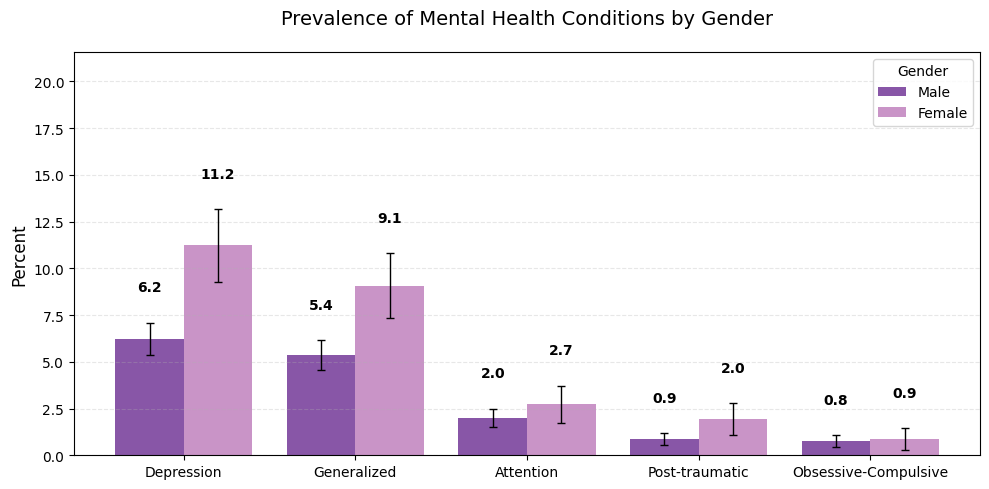

Full condition names:
Depression: Mood Disorder (Depression, Bipolar Disorder, etc)
Generalized: Anxiety Disorder (Generalized, Social, Phobia, etc)
Attention: Attention Deficit Hyperactivity Disorder
Post-traumatic: Post-traumatic Stress Disorder
Obsessive-Compulsive: Obsessive-Compulsive Disorder


In [390]:
gender_prevalence = []
for condition in top_conditions:
    for gender in ['Male', 'Female']:
        gender_prevalence.append(
            calculate_group_prevalence(condition, 'Gender', gender, gender_totals[gender])
        )

gender_prevalence_df = pd.DataFrame(gender_prevalence)

import importlib
import viz_utils as viz
importlib.reload(viz)

viz.plot_prevalence_comparison(gender_prevalence_df, group_by='Gender',
                             title="Prevalence of Mental Health Conditions by Gender")

### **Observations:**

**Significant gender disparities in major conditions:**

* **Depression:** Nearly twice as prevalent in females (11.2%) as males (6.2%)
* **Generalized anxiety:** Women report much higher rates (9.1%) compared to men (5.4%)


**Moderate differences in ADHD:**

* Slightly higher in females (2.7%) than males (2.0%)
* Error bars suggest this difference may be statistically significant


**PTSD shows marked gender difference:**

* Women's prevalence (2.0%) is more than double men's (0.9%), however low percentages need to be considered!
* Non-overlapping error bars indicate statistical significance


**OCD similar across genders:**

* Males (0.8%) and females (0.9%) show virtually identical rates
* Only condition without meaningful gender difference


**Overall pattern:**

* Women consistently report higher rates of diagnosed mental health conditions
* Gender gap most pronounced in mood and anxiety disorders
* Findings align with broader mental health literature on gender differences in diagnosis rates

### **<ins>1.7 Create a Final Query</ins>**

Final comprehensive query for your correlation analysis, focusing on:

1. **Treatment effectiveness correlation:** Analyze how seeking professional treatment correlates with work interference scores. This could reveal how effective treatment is at mitigating workplace impact.
2. **Company support factors:** Examine the correlation between company mental health resources/benefits and mental health outcomes. This could answer whether supportive workplace policies actually impact prevalence and severity of conditions.
3. **Remote work and mental health:** Investigate whether remote work correlates with different mental health patterns compared to on-site work, particularly for different age groups.
4. **Disclosure comfort vs. outcomes:** Analyze if people who feel comfortable discussing their mental health with employers/coworkers show different prevalence or treatment rates.
5. **Age factors in tech:** Look at how age correlates with both mental health prevalence and treatment-seeking behavior in the tech industry specifically.

In [408]:
updated_query = """
SELECT 
    a.UserID,
    -- Demographics
    age.AnswerText as Age,
    remote.AnswerText as RemoteWork,
    
    -- Mental health conditions
    current_mh.AnswerText as CurrentMentalHealth,
    diagnosed.AnswerText as DiagnosedMentalHealth,
    
    -- Treatment effectiveness
    treatment.AnswerText as SoughtTreatment,
    treated_interference.AnswerText as WorkInterferenceTreated,
    untreated_interference.AnswerText as WorkInterferenceUntreated,
    
    -- Company support
    benefits.AnswerText as MentalHealthBenefits,
    resources.AnswerText as MentalHealthResources,
    discussed_company.AnswerText as DiscussedMentalHealth,
    
    -- Disclosure comfort
    discussed_employer.AnswerText as DiscussedWithEmployer,
    discussed_coworkers.AnswerText as DiscussedWithCoworkers,
    neg_consequences.AnswerText as PerceivedNegativeConsequences,
    
    -- Additional context
    company_size.AnswerText as CompanySize
    
FROM 
    (SELECT DISTINCT UserID FROM Answer) a
JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 3) country ON a.UserID = country.UserID
JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 9) tech ON a.UserID = tech.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 1) age ON a.UserID = age.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 93) remote ON a.UserID = remote.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 33) current_mh ON a.UserID = current_mh.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 34) diagnosed ON a.UserID = diagnosed.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 7) treatment ON a.UserID = treatment.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 48) treated_interference ON a.UserID = treated_interference.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 49) untreated_interference ON a.UserID = untreated_interference.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 10) benefits ON a.UserID = benefits.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 16) resources ON a.UserID = resources.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 15) discussed_company ON a.UserID = discussed_company.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 58) discussed_employer ON a.UserID = discussed_employer.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 60) discussed_coworkers ON a.UserID = discussed_coworkers.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 98) neg_consequences ON a.UserID = neg_consequences.UserID
LEFT JOIN
    (SELECT UserID, AnswerText FROM Answer WHERE QuestionID = 8) company_size ON a.UserID = company_size.UserID
WHERE 
    (country.AnswerText = 'United States' OR country.AnswerText = 'United States of America')
    AND tech.AnswerText = '1'
"""
final_df = pd.read_sql_query(updated_query, conn)

print(f"Loaded {len(final_df)} respondents from US tech industry")
print(f"DataFrame shape: {final_df.shape}")
display(final_df.head())

Loaded 1828 respondents from US tech industry
DataFrame shape: (1828, 15)


,UserID,Age,RemoteWork,CurrentMentalHealth,DiagnosedMentalHealth,SoughtTreatment,WorkInterferenceTreated,WorkInterferenceUntreated,MentalHealthBenefits,MentalHealthResources,DiscussedMentalHealth,DiscussedWithEmployer,DiscussedWithCoworkers,PerceivedNegativeConsequences,CompanySize
0,1,37,No,None,None,1,None,None,Yes,None,None,None,None,No,6-25
1,5,31,Yes,None,None,0,None,None,Yes,None,None,None,None,No,100-500
2,6,33,No,None,None,0,None,None,Yes,None,None,None,None,No,6-25
3,7,35,Yes,None,None,1,None,None,No,None,None,None,None,Maybe,1-5
4,9,42,No,None,None,1,None,None,Yes,None,None,None,None,Maybe,100-500


### **<ins>1.7.1 Check for unique values and patterns first</ins>**
Check function in the `display_unique_values` function in the `viz_utils.py` file!

## **2. Data Cleaning and Preprocessing with the Final DataFrame for EDA and Correlation Analysis**

### **<ins>2.1 Missing, Invalid Values and Unique Values</ins>**

Missing values can appear in various forms in a dataset, such as:

* NaN (Not a Number)
* Empty cells in the CSV (could be treated as empty strings "" or NaN)
* Missing data can also be reflected as placeholder stings ('/', '-', '--') which need to be accounted for
* Zeros (although this depends on the context - sometimes 0 might be a valid value, other times it’s a placeholder for missing data)

In [306]:
import importlib
import viz_utils as viz
importlib.reload(viz)

viz.display_unique_values(final_df)

,Unique Count,Sample Values,Missing Count,Missing %
Age,53,['37' '31' '33' '35' '42'],0,0.0%
CompanySize,6,['6-25' '100-500' '1-5' '500-1000' '26-100'],0,0.0%
CurrentMentalHealth,6,[None 'Yes' 'No' 'Maybe' 'Possibly'],611,33.4%
DiagnosedMentalHealth,4,[None 'Yes' 'No' '-1'],611,33.4%
DiscussedMentalHealth,4,"[None 'Yes' 'No' ""I don't know""]",611,33.4%
DiscussedWithCoworkers,4,[None '1' '0' '-1'],1151,63.0%
DiscussedWithEmployer,3,[None '1' '0'],1151,63.0%
MentalHealthBenefits,5,"['Yes' 'No' ""Don't know"" ""I don't know"" 'Not eligible for coverage / NA']",0,0.0%
MentalHealthResources,4,"[None 'Yes' 'No' ""I don't know""]",611,33.4%
PerceivedNegativeConsequences,4,['No' 'Maybe' 'Yes' None],1217,66.6%


### **Missing Data Analysis - Initial Assessment:**

* **Complete demographic data:** Age, CompanySize, and SoughtTreatment variables have essentially complete data (0% missing)
* **Significant workplace discussion gaps:** Over 63% missing data for discussions with employers/coworkers
* **Remote work information limited:** RemoteWork and PerceivedNegativeConsequences both missing 66.6% of values
* **Consistent mental health data patterns:** CurrentMentalHealth, DiagnosedMentalHealth, and related workplace factors all show exactly 33.4% missing data
* **Systematic non-response likely:** The consistent missing percentages suggest survey design issues or section-specific dropout
* **Analysis limitations:** These patterns significantly restrict possible variable combinations, particularly between remote work and mental health
* **UserID uniqueness confirmed:** 1,828 distinct respondents with complete identifying information

⚙️💡 <ins>To enable meaningful statistical analysis and address inconsistencies in the raw survey data, comprehensive standardization procedures were implemented that created normalized variables, consistent binary indicators, and ordinal scales for categorical data:</ins>


### **Data Standardization and Feature Engineering:**

To prepare the data for analysis, several standardization steps were performed:

1. **Binary variables standardization**: 
   - Converted numeric responses ('0'/'1') to standardized 'Yes'/'No' values for:
     - SoughtTreatment
     - DiscussedWithEmployer
     - DiscussedWithCoworkers

2. **Work Interference quantification**:
   - Created numeric scores for work interference to enable correlation analysis:
     - 'Never' → 0
     - 'Rarely' → 1
     - 'Sometimes' → 2
     - 'Often' → 3
     - 'Not applicable to me' → NaN (excluded from analysis)
   - This ordinal scale allows us to quantify and compare interference levels


3. **Binary indicators creation**:
   - Created consistent binary indicators (1/0) for yes/no questions:
     - CurrentMentalHealth_Binary
     - DiagnosedMentalHealth_Binary
     - MentalHealthBenefits_Binary
     - MentalHealthResources_Binary
     - DiscussedMentalHealth_Binary
     - RemoteWork_Binary
   
4. **Age standardization**:
   - Converted age to numeric values
   - Created age groups for demographic analysis: <25, 25-34, 35-44, 45+
   - Capped extreme values (>90) to eliminate invalid outliers

5. **Company size encoding**:
   - Converted categorical company size ranges to ordinal values:
     - '1-5' → 1
     - '6-25' → 2
     - '26-100' → 3
     - '100-500' → 4
     - '500-1000' → 5
     - 'More than 1000' → 6
   - This allows for analysis of company size as a continuous variable


In [327]:
def clean_mental_health_data(df):
    """
    Clean and prepare the mental health dataset for analysis
    """
    df_cleaned = df.copy()
    
    # 1. Handle missing values and placeholders
    missing_placeholders = ['-1', 'none', 'None']
    df_cleaned = df_cleaned.replace(missing_placeholders, np.nan)
    
    # 2. Standardize binary responses
    binary_mapping = {'1': 'Yes', '0': 'No'}
    binary_columns = ['SoughtTreatment', 'DiscussedWithEmployer', 'DiscussedWithCoworkers']
    for col in binary_columns:
        if col in df_cleaned.columns:
            df_cleaned[col] = df_cleaned[col].replace(binary_mapping)
    
    # 3. Convert Age to numeric
    if 'Age' in df_cleaned.columns:
        df_cleaned['Age'] = pd.to_numeric(df_cleaned['Age'], errors='coerce')
    
    # 4. Create work interference scores
    for col in ['WorkInterferenceTreated', 'WorkInterferenceUntreated']:
        if col in df_cleaned.columns:
            df_cleaned[f'{col}_Score'] = df_cleaned[col].map({
                'Never': 0, 
                'Rarely': 1, 
                'Sometimes': 2, 
                'Often': 3,
                'Not applicable to me': np.nan
            })
    
    # 5. Create binary indicators
    yes_no_columns = ['CurrentMentalHealth', 'DiagnosedMentalHealth', 
                     'MentalHealthBenefits', 'MentalHealthResources', 
                     'DiscussedMentalHealth', 'RemoteWork']
    
    for col in yes_no_columns:
        if col in df_cleaned.columns:
            df_cleaned[f'{col}_Binary'] = df_cleaned[col].apply(
                lambda x: 1 if x == 'Yes' else (0 if x == 'No' else np.nan)
            )
    
    # 6. Create age groups
    if 'Age' in df_cleaned.columns:
        bins = [0, 25, 35, 45, 100]
        labels = ['<25', '25-34', '35-44', '45+']
        df_cleaned['AgeGroup'] = pd.cut(df_cleaned['Age'], bins=bins, labels=labels)
    
    # 7. Handle company size as ordinal
    if 'CompanySize' in df_cleaned.columns:
        size_mapping = {
            '1-5': 1,
            '6-25': 2,
            '26-100': 3,
            '100-500': 4,
            '500-1000': 5,
            'More than 1000': 6
        }
        df_cleaned['CompanySize_Ordinal'] = df_cleaned['CompanySize'].map(size_mapping)
    
    return df_cleaned

cleaned_df = clean_mental_health_data(final_df)

new_columns = [col for col in cleaned_df.columns if col not in final_df.columns]
print("New columns created during cleaning:")
for col in new_columns:
    print(f"- {col}")

print("\nMissing values in cleaned data:")
viz.display_unique_values(cleaned_df)

New columns created during cleaning:
- WorkInterferenceTreated_Score
- WorkInterferenceUntreated_Score
- CurrentMentalHealth_Binary
- DiagnosedMentalHealth_Binary
- MentalHealthBenefits_Binary
- MentalHealthResources_Binary
- DiscussedMentalHealth_Binary
- RemoteWork_Binary
- AgeGroup
- CompanySize_Ordinal

Missing values in cleaned data:


,Unique Count,Sample Values,Missing Count,Missing %
Age,53,[37. 31. 33. 35. 42.],1,0.1%
AgeGroup,5,"['35-44', '25-34', '45+', '<25', NaN] Categories (4, object): ['<25' < '25-34' < '35-44' < '45+']",3,0.2%
CompanySize,6,['6-25' '100-500' '1-5' '500-1000' '26-100'],0,0.0%
CompanySize_Ordinal,6,[2 4 1 5 3],0,0.0%
CurrentMentalHealth,6,[None 'Yes' 'No' 'Maybe' 'Possibly'],611,33.4%
CurrentMentalHealth_Binary,3,[nan 1. 0.],895,49.0%
DiagnosedMentalHealth,4,[None 'Yes' 'No' nan],952,52.1%
DiagnosedMentalHealth_Binary,3,[nan 1. 0.],952,52.1%
DiscussedMentalHealth,4,"[None 'Yes' 'No' ""I don't know""]",611,33.4%
DiscussedMentalHealth_Binary,3,[nan 1. 0.],747,40.9%


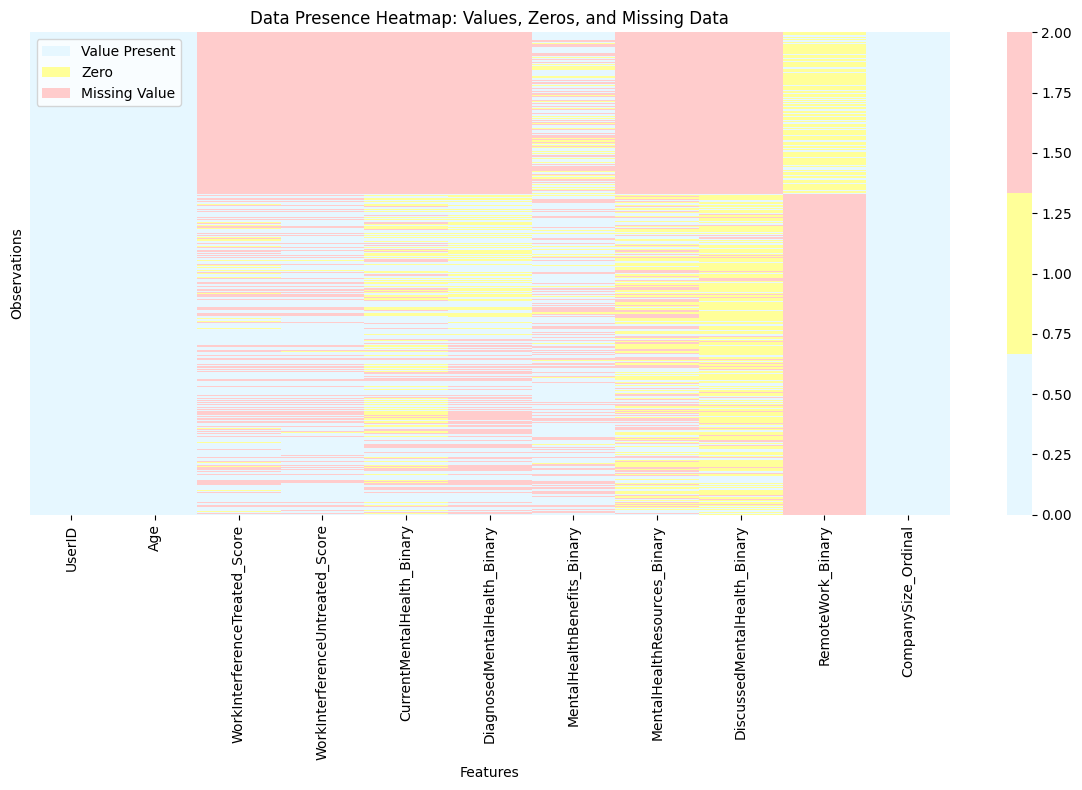

<Figure size 640x480 with 0 Axes>

In [328]:
import importlib
import viz_utils as viz
importlib.reload(viz)

viz.plot_missing_and_zeros(cleaned_df)

plt.savefig('missing_values_heatmap.png', dpi=300, bbox_inches='tight')

**The heatmap visualization shows three distinct categories of data:**

* **1. Value Present (Light Blue):** These are cells where a non-zero, non-missing value exists in the dataset. These are valid data points.
* **Zero (Light Yellow):** These are cells where the value is exactly zero. Zeros are valid data values, but they're highlighted separately because zeros can have special meaning in certain analyses (like binary indicators or rating scales).
* **Missing Value (Light Red):** These are cells where no data exists (NaN/None values in pandas).

The color bar on the side represents the numeric encoding used in the visualization

### **Data Standardization and Cleaning Impact:**

* **Enhanced analytical variables:** Created numeric scores for work interference, binary indicators for mental health conditions, and ordinal variables for company size
* **Persistent missing data:** Data gaps remained unresolved despite standardization procedures
* **Discussion variables incomplete:** DiscussedWithCoworkers (63.1%) and DiscussedWithEmployer (63.0%) still show high missing rates
* **Remote work limitations continue:** RemoteWork variables maintain 66.6% missing data
* **Binary indicators reveal patterns:** Newly created variables highlight additional missing data - MentalHealthResources_Binary (55.5%) and WorkInterference scores (>52%)
* **Limited cross-analysis possibilities:** The dataset's structural limitations prevent effective analysis between certain key variable combinations
* **Non-overlapping response patterns:** Different sections of the survey appear to have been completed by different respondent subsets

Despite these limitations, we proceeded with analysis by focusing on variable relationships with sufficient overlapping data and using company size as a bridge variable to indirectly explore connections between otherwise disconnected sections of the dataset.

### **<ins>2.2 Check/verify the data type for each feature/column</ins>**

In [391]:
data_types = cleaned_df.dtypes
print("Data types in cleaned dataset:")
for col, dtype in data_types.items():
    print(f"- {col}: {dtype}")

binary_cols = [col for col in cleaned_df.columns if col.endswith('_Binary')]
print("\nVerifying binary columns:")
for col in binary_cols:
    values = cleaned_df[col].dropna().unique()
    print(f"- {col}: {values}")

score_cols = [col for col in cleaned_df.columns if col.endswith('_Score')]
print("\nVerifying score columns:")
for col in score_cols:
    values = cleaned_df[col].dropna().unique()
    print(f"- {col}: {values}")

categorical_cols = ['AgeGroup', 'CompanySize']
print("\nVerifying categorical columns:")
for col in categorical_cols:
    if col in cleaned_df.columns:
        values = cleaned_df[col].dropna().unique()
        print(f"- {col}: {values}")

numeric_cols = cleaned_df.select_dtypes(include=['number']).columns
print("\nStatistical summary of numeric columns:")
display(cleaned_df[numeric_cols].describe())

Data types in cleaned dataset:
- UserID: int64
- Age: float64
- RemoteWork: object
- CurrentMentalHealth: object
- DiagnosedMentalHealth: object
- SoughtTreatment: object
- WorkInterferenceTreated: object
- WorkInterferenceUntreated: object
- MentalHealthBenefits: object
- MentalHealthResources: object
- DiscussedMentalHealth: object
- DiscussedWithEmployer: object
- DiscussedWithCoworkers: object
- PerceivedNegativeConsequences: object
- CompanySize: object
- WorkInterferenceTreated_Score: float64
- WorkInterferenceUntreated_Score: float64
- CurrentMentalHealth_Binary: float64
- DiagnosedMentalHealth_Binary: float64
- MentalHealthBenefits_Binary: float64
- MentalHealthResources_Binary: float64
- DiscussedMentalHealth_Binary: float64
- RemoteWork_Binary: float64
- AgeGroup: category
- CompanySize_Ordinal: int64
- Age_Capped: float64
- AgeGroup_Capped: category
- SoughtTreatment_Binary: int64

Verifying binary columns:
- CurrentMentalHealth_Binary: [1. 0.]
- DiagnosedMentalHealth_Binary

,UserID,Age,WorkInterferenceTreated_Score,WorkInterferenceUntreated_Score,CurrentMentalHealth_Binary,DiagnosedMentalHealth_Binary,MentalHealthBenefits_Binary,MentalHealthResources_Binary,DiscussedMentalHealth_Binary,RemoteWork_Binary,CompanySize_Ordinal,Age_Capped,SoughtTreatment_Binary
count,1828.000000,1827.000000,816.000000,867.000000,933.000000,876.000000,1284.000000,814.000000,1081.000000,611.000000,1828.000000,1827.000000,1828.000000
mean,2047.361050,34.024083,1.493873,2.557093,0.629153,0.719178,0.859034,0.449631,0.257169,0.345336,3.726477,33.760810,0.629650
std,1266.727591,12.459506,0.754511,0.630191,0.483291,0.449657,0.348122,0.497762,0.437276,0.475867,1.537924,8.038805,0.483031
min,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000
25%,899.750000,28.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,28.000000,0.000000
50%,2002.500000,32.000000,2.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,4.000000,32.000000,1.000000
75%,3223.250000,38.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,38.000000,1.000000
max,4218.000000,329.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,90.000000,1.000000


* **Appropriate variable encoding:** All variables have correct data types with categorical data as objects, binary indicators as numeric (float64/int64), and derived scores as float64, ensuring proper statistical processing
* **Binary indicator validation:** All seven binary columns contain only expected values (0/1), with no unexpected values that could skew analysis results
* **Score and ordinal validation:** Work interference scores contain only valid values (0-3) and company size ordinal values follow proper hierarchy (1-6), providing confidence in derived variables for correlation analysis

### **<ins>2.3 Duplicate Analysis</ins>**

In [392]:
duplicates = cleaned_df.duplicated()
duplicate_count = duplicates.sum()

print(f"Total duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    print("Sample of duplicate rows:")
    display(cleaned_df[duplicates].head())

Total duplicate rows: 0


### **<ins>2.4 Dealing with and Treating the Outliers</ins>**

Numeric columns for outlier analysis: ['UserID', 'Age', 'WorkInterferenceTreated_Score', 'WorkInterferenceUntreated_Score', 'CurrentMentalHealth_Binary', 'DiagnosedMentalHealth_Binary', 'MentalHealthBenefits_Binary', 'MentalHealthResources_Binary', 'DiscussedMentalHealth_Binary', 'RemoteWork_Binary', 'CompanySize_Ordinal', 'Age_Capped', 'SoughtTreatment_Binary']
Non-binary numeric columns for outlier analysis: ['Age', 'WorkInterferenceTreated_Score', 'WorkInterferenceUntreated_Score', 'CompanySize_Ordinal', 'Age_Capped']


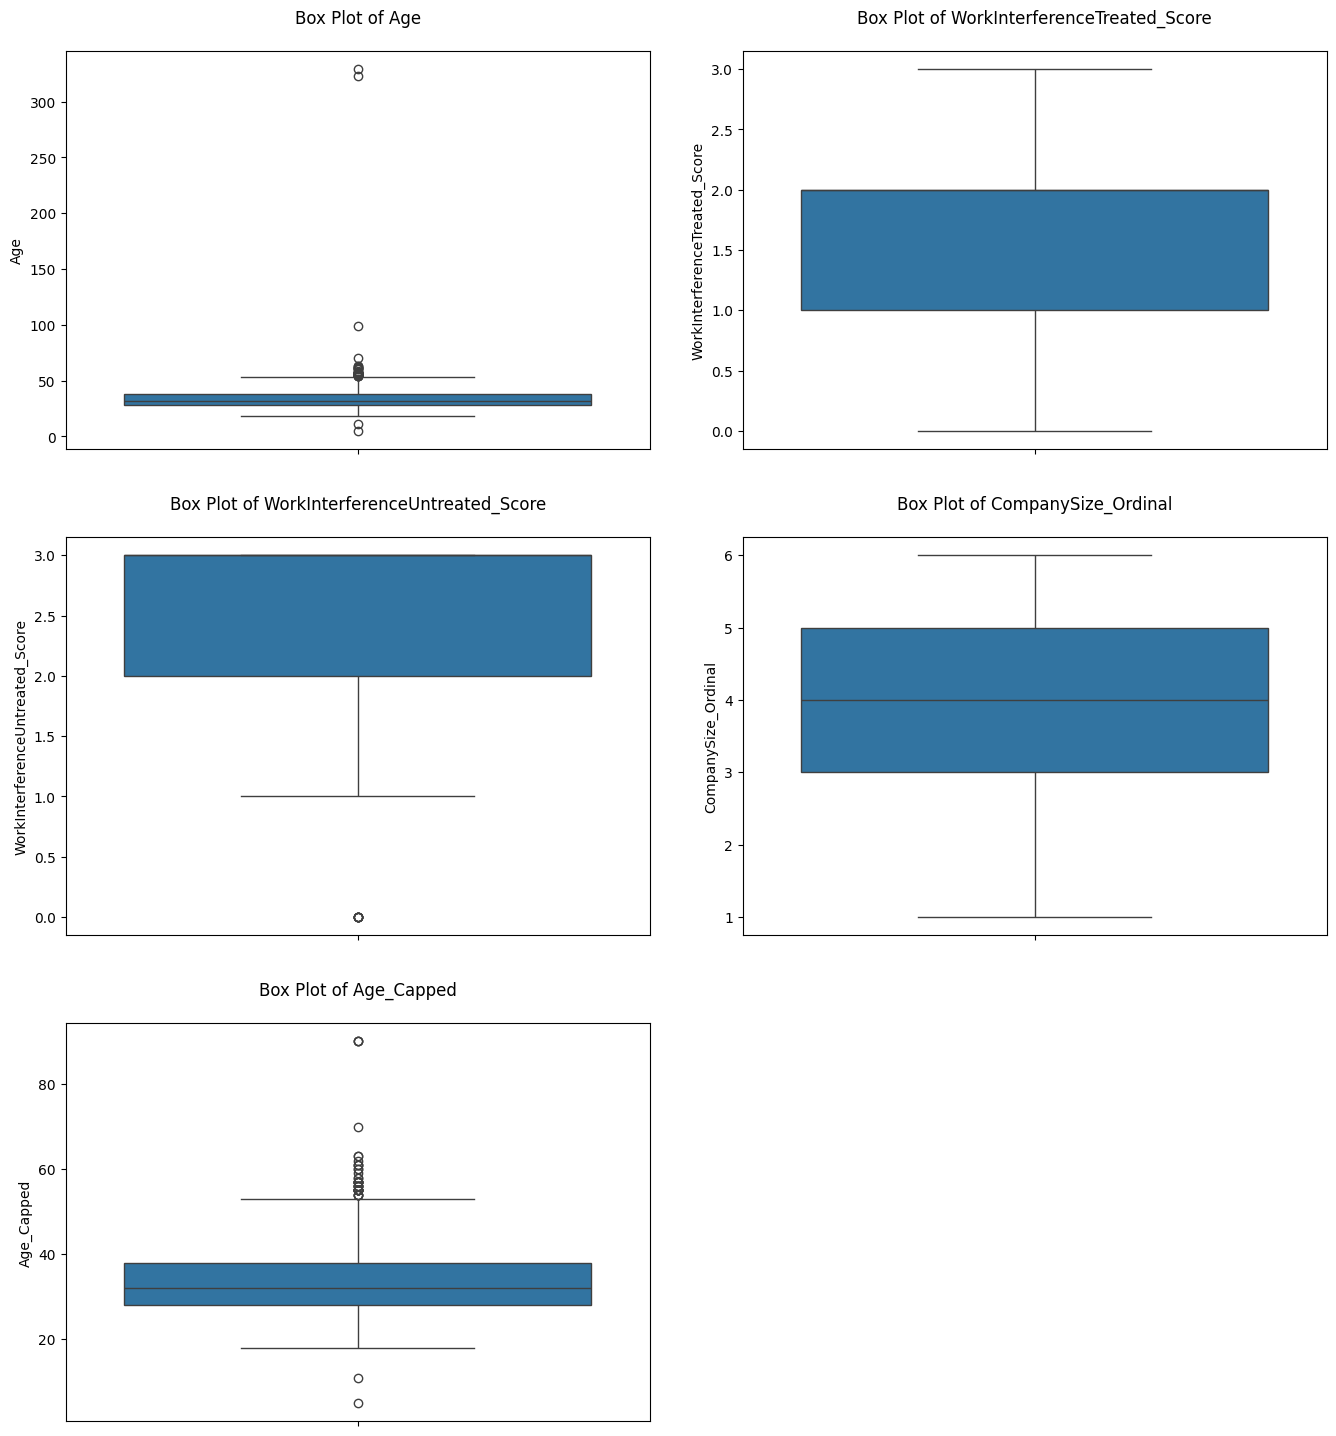


WorkInterferenceUntreated_Score value counts:
WorkInterferenceUntreated_Score
3.0    541
2.0    275
1.0     44
0.0      7
Name: count, dtype: int64


,Q1,Q3,IQR,Lower Bound,Upper Bound,Outlier Count,Outlier Percentage
UserID,899.75,3223.25,2323.5,-2585.5,6708.5,0,0.000000
Age,28.00,38.00,10.0,13.0,53.0,42,2.297593
WorkInterferenceTreated_Score,1.00,2.00,1.0,-0.5,3.5,0,0.000000
WorkInterferenceUntreated_Score,2.00,3.00,1.0,0.5,4.5,7,0.382932
CurrentMentalHealth_Binary,0.00,1.00,1.0,-1.5,2.5,0,0.000000
DiagnosedMentalHealth_Binary,0.00,1.00,1.0,-1.5,2.5,0,0.000000
MentalHealthBenefits_Binary,1.00,1.00,0.0,1.0,1.0,181,9.901532
MentalHealthResources_Binary,0.00,1.00,1.0,-1.5,2.5,0,0.000000
DiscussedMentalHealth_Binary,0.00,1.00,1.0,-1.5,2.5,0,0.000000
RemoteWork_Binary,0.00,1.00,1.0,-1.5,2.5,0,0.000000



Columns with significant outliers (>5%):


,Q1,Q3,IQR,Lower Bound,Upper Bound,Outlier Count,Outlier Percentage
MentalHealthBenefits_Binary,1.0,1.0,0.0,1.0,1.0,181,9.901532


In [409]:
numeric_cols = cleaned_df.select_dtypes(include=['number']).columns.tolist()
print(f"Numeric columns for outlier analysis: {numeric_cols}")
non_binary_numeric_cols = [col for col in numeric_cols 
                          if not col.endswith('_Binary') and col != 'UserID']
print(f"Non-binary numeric columns for outlier analysis: {non_binary_numeric_cols}")

n_cols = len(non_binary_numeric_cols)
n_rows = (n_cols + 1) // 2 

plt.figure(figsize=(14, 5 * n_rows)) 
for i, col in enumerate(non_binary_numeric_cols, 1):
    plt.subplot(n_rows, 2, i) 
    sns.boxplot(y=cleaned_df[col])
    plt.title(f'Box Plot of {col}', pad=20) 
    
plt.tight_layout(pad=3)  
plt.show()

print("\nWorkInterferenceUntreated_Score value counts:")
print(cleaned_df['WorkInterferenceUntreated_Score'].value_counts())

outlier_stats = {}
for col in numeric_cols:
    if cleaned_df[col].isna().all():
        continue

    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = cleaned_df[(cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)]
    outlier_count = len(outliers)
    
    outlier_stats[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outlier Count': outlier_count,
        'Outlier Percentage': (outlier_count / len(cleaned_df)) * 100
    }

outlier_df = pd.DataFrame.from_dict(outlier_stats, orient='index')
display(outlier_df)

significant_outliers = outlier_df[outlier_df['Outlier Percentage'] > 5]
if not significant_outliers.empty:
    print("\nColumns with significant outliers (>5%):")
    display(significant_outliers)

### **Outlier Analysis Observations:**

* **Age outliers clearly evident:** Uncapped Age data shows extreme outliers beyond 100 years, including values up to 329, justifying the implementation of Age_Capped 
* **Age_Capped shows expected distribution:** After capping at 90 years, the distribution appears more realistic with median around 32 years and most values between 28-38
* **Work Interference patterns:** Both treated and untreated interference scores show discrete values (0-3) with expected distributions - untreated scores skewed toward higher values (mostly 2-3)
* **MentalHealthBenefits_Binary unique case:** Shows 9.9% outliers due to zero IQR (all values concentrated at 1), a statistical artifact rather than true outliers
* **Effective outlier management:** Age capping at 90 years successfully addressed the most problematic outliers while preserving the overall age distribution and maintaining data integrity for analysis

#### **Next steps:** 
1. Create a new column Age_Capped with values capped at 90 years
2. Create an updated AgeGroup_Capped column based on these capped values
   
New columns (Age_Capped and AgeGroup_Capped) to be used for all further analyses instead of the original age columns.

In [397]:
cleaned_df['Age_Capped'] = cleaned_df['Age'].copy()
cleaned_df.loc[cleaned_df['Age'] > 90, 'Age_Capped'] = 90

print("Original Age statistics:")
print(cleaned_df['Age'].describe())
print("\nCapped Age statistics:")
print(cleaned_df['Age_Capped'].describe())

bins = [0, 25, 35, 45, 90]
labels = ['<25', '25-34', '35-44', '45+']
cleaned_df['AgeGroup_Capped'] = pd.cut(cleaned_df['Age_Capped'], bins=bins, labels=labels)

age_group_counts = cleaned_df['AgeGroup_Capped'].value_counts().sort_index()
print("\nCapped Age Group distribution:")
print(age_group_counts)

Original Age statistics:
count    1827.000000
mean       34.024083
std        12.459506
min         5.000000
25%        28.000000
50%        32.000000
75%        38.000000
max       329.000000
Name: Age, dtype: float64

Capped Age statistics:
count    1827.000000
mean       33.760810
std         8.038805
min         5.000000
25%        28.000000
50%        32.000000
75%        38.000000
max        90.000000
Name: Age_Capped, dtype: float64

Capped Age Group distribution:
AgeGroup_Capped
<25      226
25-34    953
35-44    511
45+      137
Name: count, dtype: int64


### **Summary of Outlier Analysis**

**1. Age Variable:**

* Identified extreme values (up to 323 years) which are clearly erroneous
* Action taken: Capped age values at 90 years to maintain reasonable maximum
* Created a new 'Age_Capped' column to preserve original data while using capped values for analysis
* Updated age groups based on capped values

**2. Work Interference Scores:**

* WorkInterferenceTreated_Score: No problematic outliers, values within expected range (0-3)
* WorkInterferenceUntreated_Score: Found 7 values at 0.0 flagged as potential outliers (rare cases where untreated conditions never interfere with work)
* Action taken: Kept all values as they represent valid and meaningful data points
* Distribution shows most untreated conditions "Often" (3.0) interfere with work, which is conceptually valid


**3. Binary Variables:**

Several binary columns showed up in outlier detection due to statistical artifacts
MentalHealthBenefits_Binary showed 9.9% "outliers" due to zero IQR
Action taken: Ignored outlier classification for binary variables as not meaningful
Binary variables by definition can only have two valid values, so outlier concept doesn't apply


**4. Company Size Ordinal:**

No outliers detected, all values within expected range (1-6)
Distribution appears reasonable with most respondents in medium to large companies

## **3. Exploratory Data Analysis (EDA): Bivariant and Correlation Analysis**

For our dataset with different variable types, we'll need different correlation approaches:

1. **Pearson correlation:** For continuous-continuous variable pairs (like age and work interference scores)
2. **Point-biserial correlation:** For binary-continuous pairs (like treatment status and work interference scores)
3. **Phi coefficient:** For binary-binary relationships (like treatment status and diagnosis status)



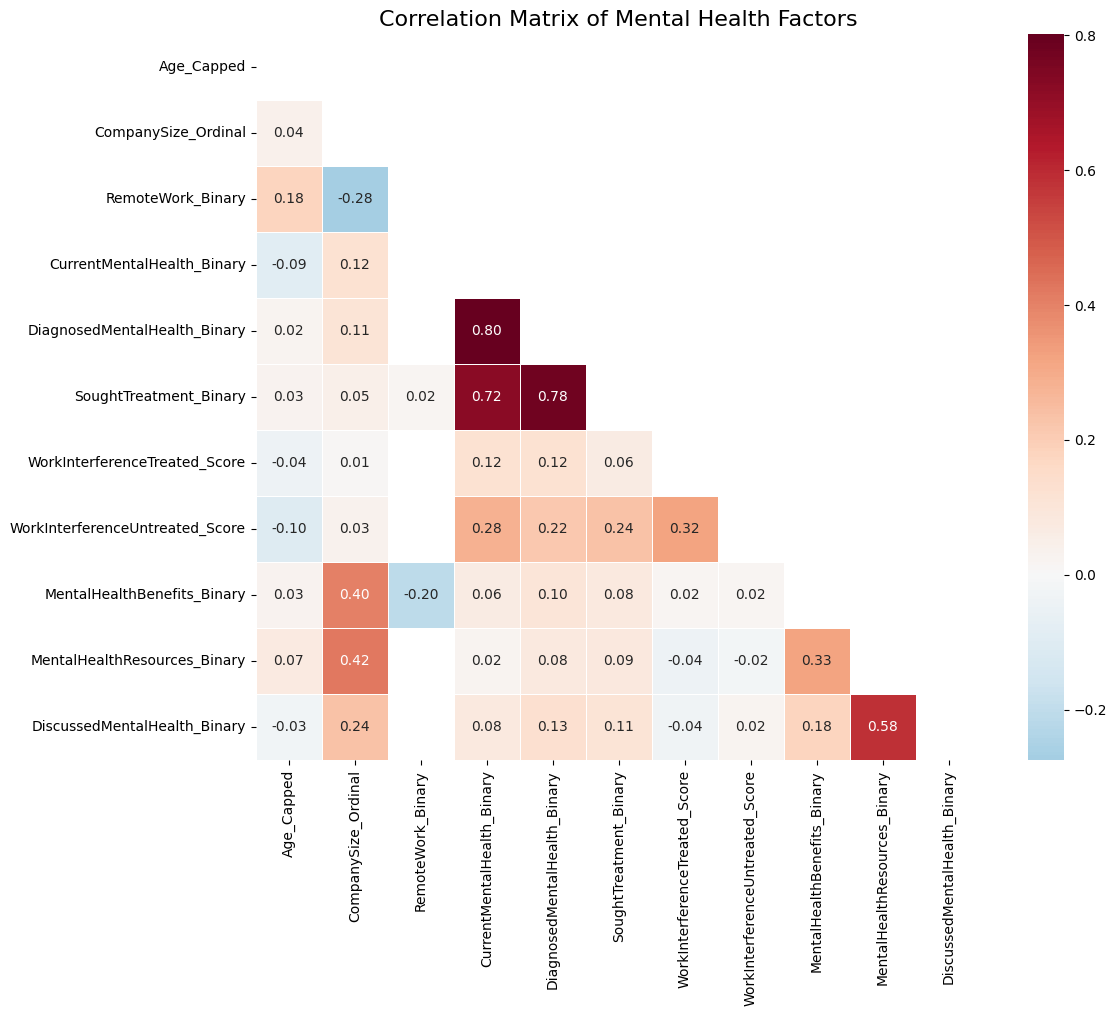

Strongest correlations found:


,Variable 1,Variable 2,Correlation
1,CurrentMentalHealth_Binary,DiagnosedMentalHealth_Binary,0.801438
3,DiagnosedMentalHealth_Binary,SoughtTreatment_Binary,0.776564
2,CurrentMentalHealth_Binary,SoughtTreatment_Binary,0.721974
13,MentalHealthResources_Binary,DiscussedMentalHealth_Binary,0.584627
10,CompanySize_Ordinal,MentalHealthResources_Binary,0.422829
8,CompanySize_Ordinal,MentalHealthBenefits_Binary,0.404679
11,MentalHealthBenefits_Binary,MentalHealthResources_Binary,0.325529
7,WorkInterferenceTreated_Score,WorkInterferenceUntreated_Score,0.322533
4,CurrentMentalHealth_Binary,WorkInterferenceUntreated_Score,0.280054
0,CompanySize_Ordinal,RemoteWork_Binary,-0.275071


In [369]:
correlation_columns = [
    # Demographics
    'Age_Capped',
    'CompanySize_Ordinal',
    'RemoteWork_Binary',
    
    # Mental health conditions
    'CurrentMentalHealth_Binary',
    'DiagnosedMentalHealth_Binary',
    
    # Treatment and interference
    'SoughtTreatment_Binary',  # Convert first if needed
    'WorkInterferenceTreated_Score',
    'WorkInterferenceUntreated_Score',
    
    # Company support
    'MentalHealthBenefits_Binary', 
    'MentalHealthResources_Binary',
    'DiscussedMentalHealth_Binary'
]

# Ensure we have SoughtTreatment as binary
if 'SoughtTreatment_Binary' not in cleaned_df.columns:
    cleaned_df['SoughtTreatment_Binary'] = cleaned_df['SoughtTreatment'].map({'Yes': 1, 'No': 0})

correlation_df = cleaned_df[correlation_columns].copy()
correlation_matrix = correlation_df.corr(method='pearson')

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, square=True, linewidths=.5)
plt.title('Correlation Matrix of Mental Health Factors', fontsize=16)
plt.tight_layout()
plt.show()

strong_correlations = []
for i in range(len(correlation_columns)):
    for j in range(i):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) >= 0.2: 
            strong_correlations.append({
                'Variable 1': correlation_columns[j],
                'Variable 2': correlation_columns[i],
                'Correlation': correlation
            })

strong_corr_df = pd.DataFrame(strong_correlations).sort_values('Correlation', key=abs, ascending=False)
print("Strongest correlations found:")
display(strong_corr_df)

⚙️💡Given the vast amount of missing values, the same approach as the correlation matrix was used for analyzing relationships between variables by applying "pairwise deletion" in our visualization functions. This means: 

1. For each specific analysis/visualization, we only drop rows where one or more of the specific variables being analyzed in that chart have missing values
2. We keep all other rows with complete data for those specific variables
3. This is exactly what the correlation matrix does - it calculates each correlation coefficient using all available pairs of observations

This approach maximizes the data used for each specific analysis rather than throwing away all rows with any missing values, which would dramatically reduce the sample size. It ensures visualizations are consistent with correlation findings, as they use the same methodology for handling missing data.

### **Correlation Analysis Explanation for Range and Meaning:**


**Range:** Correlation coefficients range from -1 to +1
Sign:

* Positive values (+): Variables move in the same direction
* Negative values (-): Variables move in opposite directions


**Magnitude:** The absolute value indicates relationship strength

**Strength Guidelines:**

- <ins>0.00 to 0.19:</ins> Very weak relationship
- <ins>0.20 to 0.39:</ins> Weak relationship
- <ins>0.40 to 0.59:</ins> Moderate relationship
- <ins>0.60 to 0.79:</ins> Strong relationship
- <ins>0.80 to 1.00:</ins> Very strong relationship

**Important Considerations:**

- Correlation does not imply causation
- A correlation of 0 means no linear relationship (but non-linear relationships may exist)
- Perfect correlations (exactly -1 or +1) are rare in real-world data
- The practical significance of a correlation depends on the context and field of study

### **Correlation Visualizations**

The detailed code for the vizualization functions can be found in the viz_utils.py file!

#### **1. Treatment Effectiveness Visualization**

Using the paired t-test here because we're comparing the same individuals under two conditions (treated vs. untreated), making this a within-subjects design.

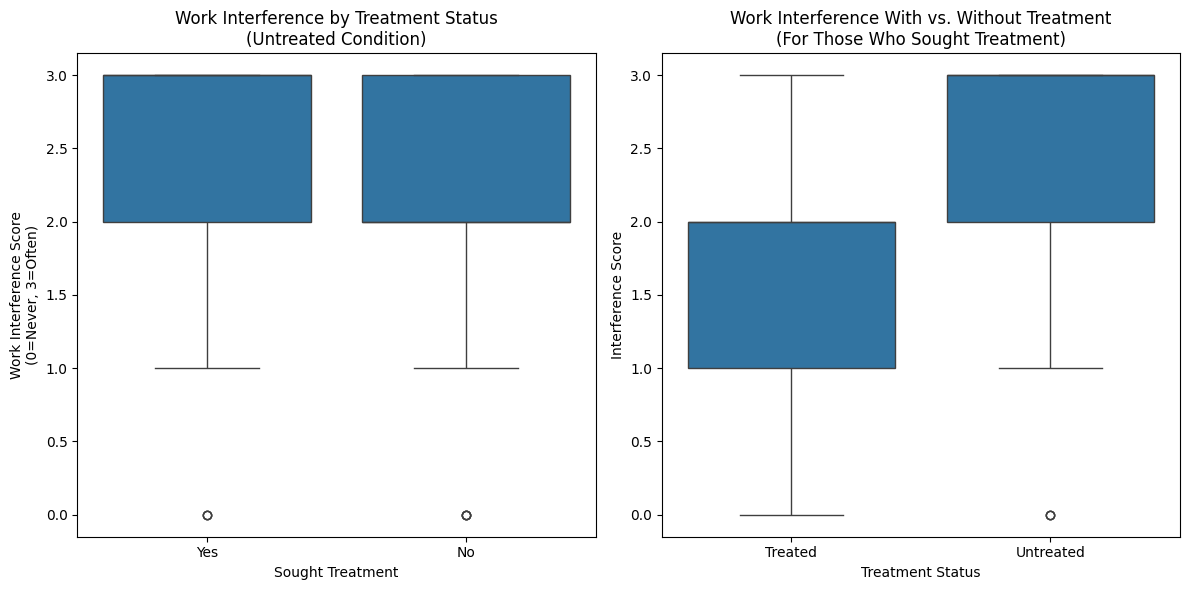

In [398]:
import importlib
import viz_utils as viz
importlib.reload(viz)

fig = viz.plot_treatment_effectiveness(cleaned_df)
plt.show()

* **Treatment Doesn't Eliminate Work Interference:** The untreated condition shows similar levels of work interference regardless of whether someone sought treatment (left plot). This suggests that simply seeking treatment doesn't change the untreated interference level.
* **Treatment Shows Positive Effects:** The right plot shows a substantial difference between treated and untreated interference scores for those who sought treatment. The treated condition has a lower median score (around 1.5) compared to the untreated condition (around 2.5).
* **Variability in Treatment Response:** The wider range of the "Treated" box suggests more variability in how people respond to treatment - some experience significant improvement (scores near 0), while others show less improvement.
* **Persistent High Interference:** Both plots show that even with treatment, some individuals continue to experience high levels of work interference (scores of 3.0), indicating that treatment isn't universally effective.
* **Baseline Severity:** The similar distributions in the left plot suggest that baseline severity of mental health conditions (as measured by work interference) doesn't strongly predict whether someone seeks treatment.

* For the left plot (Untreated Condition), both "Yes" and "No" categories seem to have very similar distributions with minimums around 1.0 and maximums at 3.0, with the box representing the interquartile range (IQR) from approximately 2.0 to 3.0.
* For the right plot (With vs. Without Treatment), the "Untreated" category appears to have a minimum at 1.0, but the "Treated" category shows a full range from 0.0 to 3.0. The missing whisker at the bottom of the "Untreated" box suggests that the minimum value in that category is the same as the lower quartile value (around 2.0).
* The circles at the bottom of some boxes represent outliers - values that fall outside the typical range (typically 1.5 × IQR from the quartiles).



#### **2. Company Support Factors**

Using **Chi-square test** here because we're examining the relationship between categorical variables (company size categories and whether resources are provided), making this the appropriate test for independence.

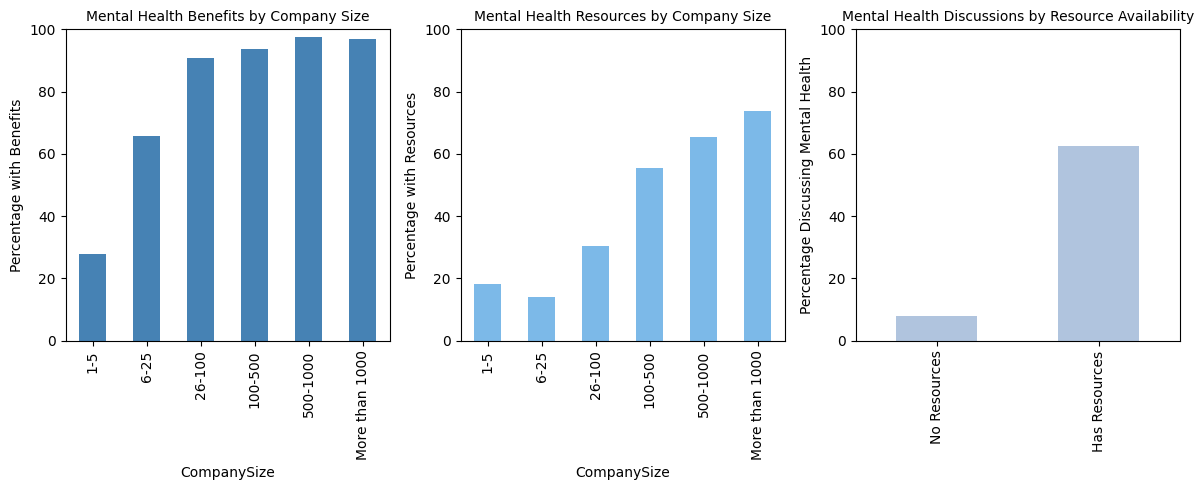

In [399]:
importlib.reload(viz)
fig = viz.plot_company_support_factors(cleaned_df)
plt.show()

**Benefits vs. Company Size:** There's a clear pattern where very small companies (1-5 employees) have significantly fewer mental health benefits than all other company sizes. Interestingly, mid-size and large companies (100+ employees) have similar rates of benefits provision.

**Resources vs. Company Size:** The pattern for resources is more varied than benefits. The largest companies (1000+) provide the most resources, but smaller firms (6-25 employees) offer more resources than slightly larger ones (26-100), suggesting that company culture may be more important than just size.

**Discussion by Resources:** There's a dramatic difference in mental health discussions between workplaces with and without resources - people are about 6 times more likely to discuss mental health when resources are available. This suggests that providing resources creates an environment where these discussions are normalized.

#### **3. Remote Work and Mental Health**

Using point-biserial correlation here because we're examining the relationship between a binary variable (remote work) and continuous variables (mental health measures), which is the appropriate version of **Pearson correlation** for this data type combination.

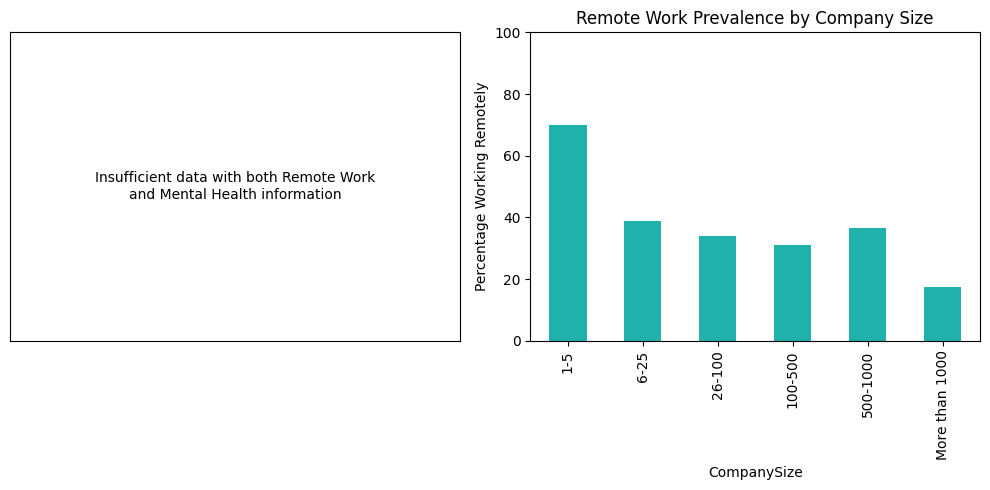

In [400]:
importlib.reload(viz)
fig = viz.plot_remote_work_relationships(cleaned_df)
plt.show()

In [401]:
print("RemoteWork value counts:")
print(cleaned_df['RemoteWork'].value_counts())
print(f"Missing values: {cleaned_df['RemoteWork'].isna().sum()}")

print("\nCurrentMentalHealth_Binary value counts:")
print(cleaned_df['CurrentMentalHealth_Binary'].value_counts())
print(f"Missing values: {cleaned_df['CurrentMentalHealth_Binary'].isna().sum()}")

try:
    test_group = cleaned_df.groupby('RemoteWork')['CurrentMentalHealth_Binary'].mean()
    print("\nSuccessful groupby result:")
    print(test_group)
except Exception as e:
    print(f"\nError in groupby: {e}")

RemoteWork value counts:
RemoteWork
No     400
Yes    211
Name: count, dtype: int64
Missing values: 1217

CurrentMentalHealth_Binary value counts:
CurrentMentalHealth_Binary
1.0    587
0.0    346
Name: count, dtype: int64
Missing values: 895

Successful groupby result:
RemoteWork
No    NaN
Yes   NaN
Name: CurrentMentalHealth_Binary, dtype: float64


<ins>The debugging output shows:</ins>

RemoteWork has 611 valid entries (400 No + 211 Yes) and 1217 missing values
CurrentMentalHealth_Binary has 933 valid entries (587 Yes + 346 No) and 895 missing values
The groupby result returns NaN for both "No" and "Yes" categories

This means that while both columns have valid data individually, there's no overlap between rows that have valid data for both variables. In other words, the respondents who answered the remote work question are completely different from those who answered the mental health question.

**Company size as Bridge between Remote Work and Mental Health ressources:**

To address the data limitation in directly connecting remote work with mental health variables, we'll use company size as a bridging factor. The following visualization explores how remote work patterns and mental health resource availability both vary by company size, potentially revealing indirect relationships between these key factors.

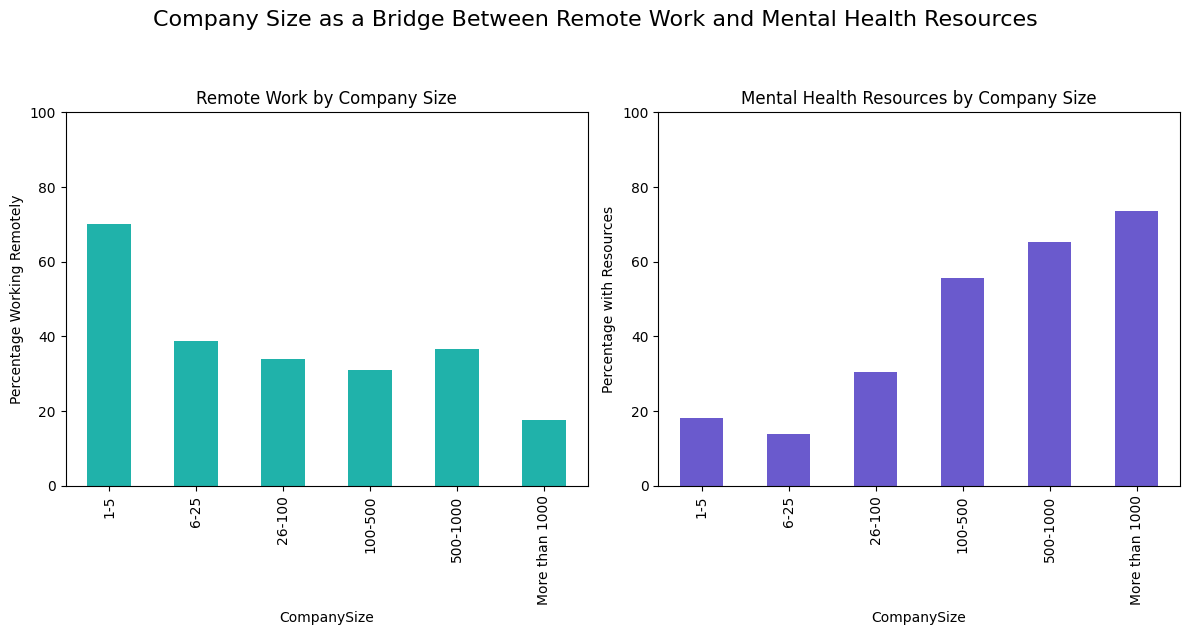

In [402]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 1. Remote work by company size (your existing successful plot)
df_remote_size = cleaned_df.dropna(subset=['CompanySize', 'RemoteWork_Binary'])
remote_by_size = df_remote_size.groupby('CompanySize')['RemoteWork_Binary'].mean() * 100

size_order = ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000']
available_sizes = [size for size in size_order if size in remote_by_size.index]
remote_by_size = remote_by_size.reindex(available_sizes)

remote_by_size.plot(kind='bar', color='#20b2aa', ax=axes[0])
axes[0].set_title('Remote Work by Company Size')
axes[0].set_ylabel('Percentage Working Remotely')
axes[0].set_ylim(0, 100)

# 2. Mental health resources by company size
df_mh_size = cleaned_df.dropna(subset=['CompanySize', 'MentalHealthResources_Binary'])
mh_by_size = df_mh_size.groupby('CompanySize')['MentalHealthResources_Binary'].mean() * 100

available_sizes = [size for size in size_order if size in mh_by_size.index]
mh_by_size = mh_by_size.reindex(available_sizes)

mh_by_size.plot(kind='bar', color='#6a5acd', ax=axes[1])
axes[1].set_title('Mental Health Resources by Company Size')
axes[1].set_ylabel('Percentage with Resources')
axes[1].set_ylim(0, 100)

plt.suptitle('Company Size as a Bridge Between Remote Work and Mental Health Resources', 
            fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

* **Small companies (1-5 employees)** show the highest remote work adoption at approximately 70%, but offer mental health resources to only about 18% of their workforce.
* **Medium companies (26-500 employees)** demonstrate a balanced approach with moderate remote work (30-35%) and increasing mental health resources (30-55%).
* **Large companies (>1000 employees)** have the lowest remote work prevalence at about 18%, but provide the highest level of mental health resources at approximately 73%.

This pattern suggests that while small companies leverage remote work flexibility, they may lack the infrastructure or resources to provide formal mental health support, creating a potential vulnerability for remote workers in smaller organizations.

**Mental Health Support Structure by Company Size:**

Building on the company size analysis, we can further examine how formal mental health benefits and workplace discussion comfort vary across different organizational scales. This additional perspective can helps to understand the comprehensive mental health support ecosystem available to tech workers in companies of varying sizes.

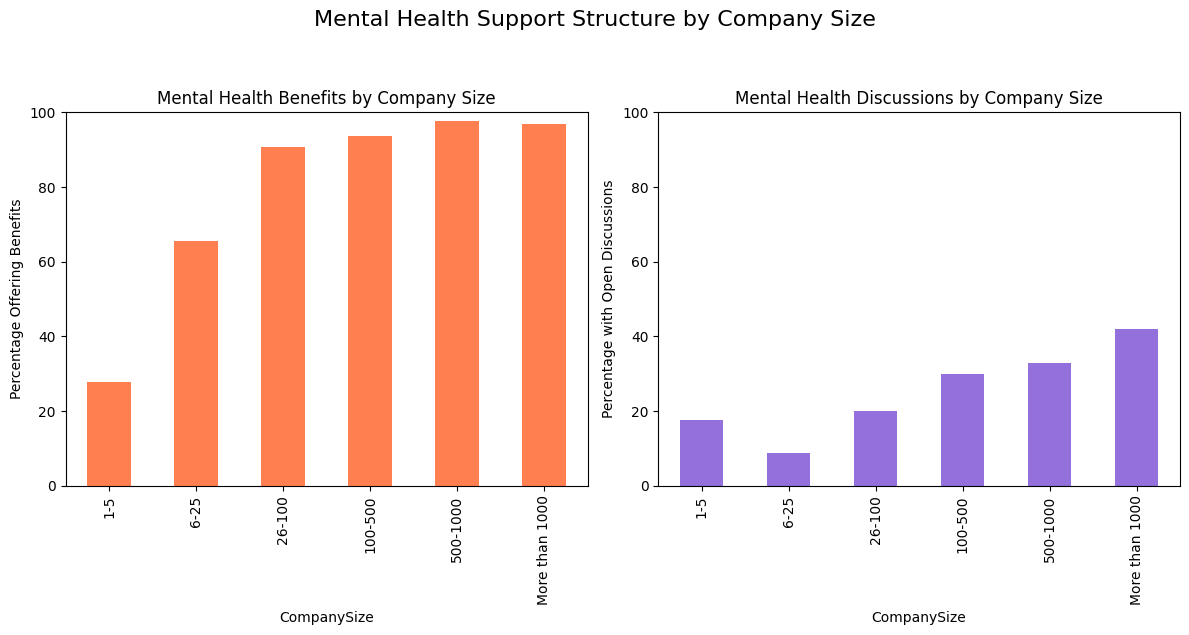

In [403]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 1. Mental health benefits by company size
df_benefits_size = cleaned_df.dropna(subset=['CompanySize', 'MentalHealthBenefits_Binary'])
benefits_by_size = df_benefits_size.groupby('CompanySize')['MentalHealthBenefits_Binary'].mean() * 100

available_sizes = [size for size in size_order if size in benefits_by_size.index]
benefits_by_size = benefits_by_size.reindex(available_sizes)

benefits_by_size.plot(kind='bar', color='#ff7f50', ax=axes[0])
axes[0].set_title('Mental Health Benefits by Company Size')
axes[0].set_ylabel('Percentage Offering Benefits')
axes[0].set_ylim(0, 100)

# 2. Mental health discussions by company size (if data available)
df_discuss_size = cleaned_df.dropna(subset=['CompanySize', 'DiscussedMentalHealth_Binary'])
if len(df_discuss_size) > 30:  # Check if we have enough data
    discuss_by_size = df_discuss_size.groupby('CompanySize')['DiscussedMentalHealth_Binary'].mean() * 100
    
    available_sizes = [size for size in size_order if size in discuss_by_size.index]
    discuss_by_size = discuss_by_size.reindex(available_sizes)
    
    discuss_by_size.plot(kind='bar', color='#9370db', ax=axes[1])
    axes[1].set_title('Mental Health Discussions by Company Size')
    axes[1].set_ylabel('Percentage with Open Discussions')
    axes[1].set_ylim(0, 100)
else:
    axes[1].text(0.5, 0.5, "Insufficient data for mental health discussions by company size", 
               ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.suptitle('Mental Health Support Structure by Company Size', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

* **Formal benefits** follow a clear scale-dependent pattern, with nearly 100% of large companies (500+ employees) offering mental health benefits compared to only ~28% of the smallest companies.
* **Open discussions about mental health** show a generally positive relationship with company size but with a less dramatic increase. Even in the largest companies, only about 40% of respondents report comfortable mental health discussions.
* The **6-25 employee company size** shows an interesting anomaly in mental health discussions, with the lowest percentage (~10%), despite having higher benefits coverage than the smallest companies.

This suggests that while larger companies have more formal structures in place, the cultural comfort with mental health discussions lags behind the formal benefits provision. Additionally, small to mid-size companies may face particular challenges in creating environments where mental health can be openly discussed.

These visualizations effectively bridge the gap in our analysis where direct relationships between remote work and mental health couldn't be established due to data limitations. Instead, they reveal how company size mediates both factors, providing valuable indirect insights into potential areas of focus for workplace mental health initiatives.

#### **4. Diagnosis, Treatment and Work Interference**

Using **Phi coefficient (derived from Chi-square)** as it's the appropriate measure of association between two binary variables.

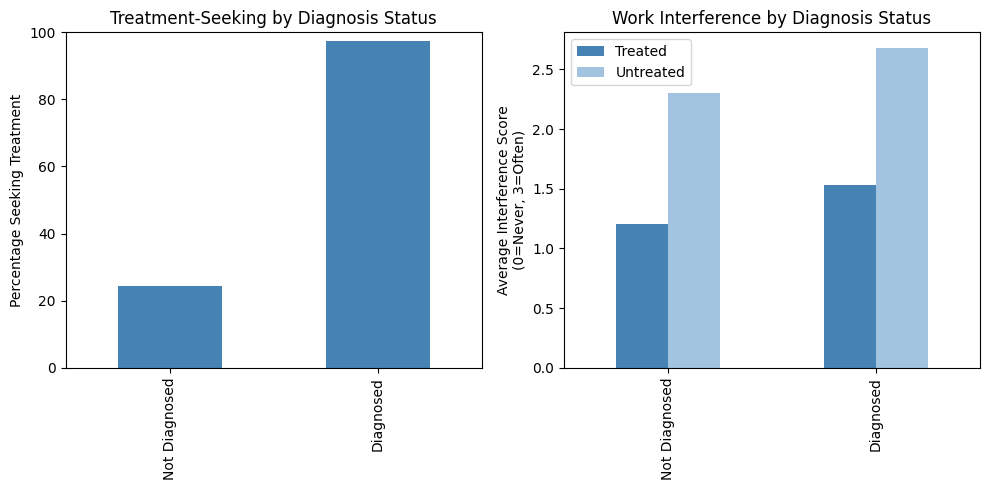

In [404]:
importlib.reload(viz)
fig = viz.plot_diagnosis_treatment_interference(cleaned_df)
plt.show()

**Treatment-Seeking by Diagnosis Status:** There's a significant difference in treatment-seeking behavior between diagnosed and undiagnosed individuals. Those with a formal diagnosis are nearly 4 times more likely to seek treatment (almost 100% vs. around 25%). This highlights how critical diagnosis is as a gateway to treatment.

**Work Interference by Diagnosis Status:**

* For both diagnosed and undiagnosed individuals, untreated mental health conditions (blue bars) interfere with work substantially more than treated conditions.
* Diagnosed individuals report higher work interference overall compared to undiagnosed individuals, both with and without treatment.
* The treatment effect (difference between untreated and treated bars) appears similar regardless of diagnosis status, suggesting treatment is effective for both groups.

#### **5. Age Factors in Mental Health**

Using a **one-way ANOVA**, which is appropriate for comparing means across more than two independent groups.

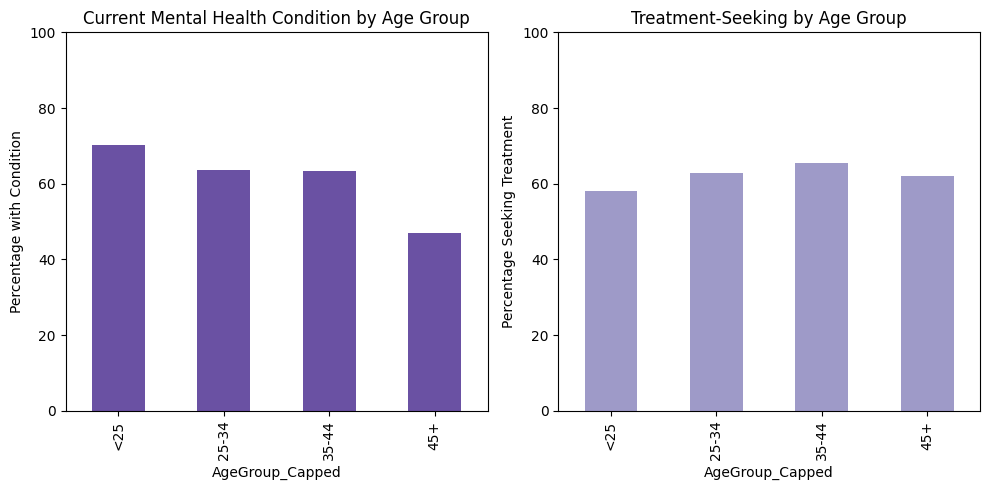

In [405]:
importlib.reload(viz)
fig = viz.plot_age_mental_health(cleaned_df)
plt.show()

**Mental Health Conditions by Age:** There's a clear age-related pattern where younger tech workers (under 25) report the highest rates of mental health conditions (around 70%), with a steady decline across age groups. The 45+ age group reports significantly lower rates (around 45%), suggesting either lower prevalence or different reporting tendencies among older workers.

**Treatment-Seeking by Age:** Interestingly, treatment-seeking behavior shows a slight inverse pattern. Middle-aged workers (35-44) are most likely to seek treatment (about 65%), while the youngest workers (under 25) seek treatment at slightly lower rates (about 58%) despite having higher reported conditions.

These patterns suggest potential generational differences in both mental health prevalence and attitudes toward treatment in the tech industry. Younger workers may be more likely to acknowledge mental health conditions but slightly less likely to seek professional help compared to their middle-aged colleagues.


## **4. Summary of EDA and Insights**

### **General observations** 

Based on the survey data, several key demographics and patterns emerge that provide context for our analysis:

* **Tech Industry Composition:** The vast majority of respondents (84.2%) were employees rather than self-employed individuals, and 68.5% worked at tech companies.
* **Company Size Distribution:** The dataset includes a fairly balanced representation across company sizes, with slightly higher representation from larger companies (21.6% from companies with 1000+ employees) and mid-size companies (19.5% from companies with 26-100 employees).
* **Gender Imbalance:** There is a significant gender disparity in the sample, with males constituting 72.4% of respondents compared to 24.4% females and small percentages of other gender identities (3.2% combined). This reflects the broader gender imbalance in the tech industry but may also impact how representative the mental health findings are across genders.
* **Age Distribution:** The tech workforce represented is predominantly young to middle-aged, with 69.4% of respondents between 25-39 years old. This skew toward younger professionals should be considered when interpreting mental health trends.
* **Geographical Concentration:** The survey is heavily US-centric, with United States respondents accounting for the majority of the dataset (2,604 respondents or approximately 61.8% when combining "United States" and "United States of America" categories).
* **Lack of Racial/Ethnic Diversity:** The survey shows significant racial homogeneity, with 88.6% of respondents identifying as White. This severe underrepresentation of other racial/ethnic groups (particularly Black/African American at 1.5% and Hispanic at 0.2%) presents a substantial limitation in understanding mental health challenges across diverse populations in tech.

**Potential Biases**

These demographic patterns highlight several potential biases that should be considered when interpreting findings:

* **Selection Bias:** The survey may have attracted participants who were already interested in mental health topics, potentially overrepresenting those experiencing mental health challenges.
* **Representation Bias:** The homogeneous sample (predominantly white, male, US-based) limits the generalizability of findings to the broader, more diverse global tech industry.
* **Reporting Bias:** Cultural differences in mental health stigma across countries, age groups, and company environments may affect willingness to disclose mental health conditions.
* **Missing Data Patterns:** As observed in our analysis, certain survey sections had high non-response rates, creating challenges in establishing direct relationships between some variables.

### **Correlation Analysis Summary**

Our correlation analysis revealed several significant relationships between mental health factors and workplace characteristics:

* **Mental Health Diagnosis and Treatment (0.72-0.80):** Strong correlations between diagnosed conditions, current mental health status, and seeking treatment indicate that formal diagnosis significantly increases likelihood of seeking help.
* **Company Resources and Mental Health Discussions (0.58):** Companies providing mental health resources demonstrated more open environments for mental health discussions, suggesting resources help normalize these conversations.
* **Company Size and Support Systems (0.40-0.42):** Larger companies consistently offered more mental health benefits and resources, with our visualizations showing nearly 100% of large companies (500+ employees) providing benefits compared to only ~28% of the smallest companies.
* **Remote Work and Company Characteristics (-0.28):** Remote work showed an inverse relationship with company size, with small companies (1-5 employees) having the highest remote work rates (around 70%) while the largest companies had the lowest (around 18%).
* **Mental Health Support Gap:** Our bridging analysis revealed that while small companies leverage remote work flexibility, they provide significantly fewer mental health resources and benefits, creating a potential vulnerability for remote workers in smaller organizations.
* **Work Interference Patterns (0.22-0.32):** Mental health conditions were found to affect workplace performance regardless of treatment status, with moderate correlation between treated and untreated work interference scores.

These findings highlight the complex interplay between organizational factors and mental health support in the tech industry. The inverse relationship between remote work prevalence and mental health resource availability across company sizes suggests that organizational size mediates both factors and reveals potential gaps in support systems for remote workers, particularly in smaller companies. This indicates valuable areas for workplace policy interventions to better support mental health across diverse work arrangements in the tech industry.


## **5. Improvements**

**Methodological Improvements:**

* **Missing Data Handling:** Implement more sophisticated approaches to handle missing data, such as multiple imputation techniques, rather than simply dropping incomplete rows for each analysis.
* **Standardized Mental Health Measures:** Incorporate validated psychological assessment tools in future surveys to enable more precise and comparable measurement of mental health conditions.
* **Mixed Methods Approach:** Supplement quantitative analysis with qualitative interviews to gain deeper insights into the "why" behind the statistical patterns observed.
* **Propensity Score Matching:** When comparing groups (e.g., remote vs. in-office workers), use matching techniques to ensure more comparable samples and strengthen causal inferences.

**Reporting and Visualization Improvements:**

* **Interactive Dashboards:** Develop interactive visualizations that allow stakeholders to explore patterns across multiple variables simultaneously.
* **Confidence Intervals:** Include confidence intervals in statistical reporting to better communicate the precision and reliability of findings.
* **Standardized Effect Sizes:** Report effect sizes alongside statistical significance to better communicate the practical importance of findings.

**Data Collection Recommendations:**

* **Representative Sampling:** Implement sampling strategies to ensure better representation across demographic groups, particularly improving racial/ethnic diversity and gender balance.
* **Survey Design:** Redesign the survey to ensure better completion rates for all sections, reducing the pattern of missing data that limited certain analyses.
* **Consistent Measurement:** Use consistent response formats across related questions to facilitate more direct comparisons between variables.